### 导入必备的包

In [2]:
import pandas as pd
import numpy as np
import optuna
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import gc
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
import warnings
import joblib


# RF
from sklearn.ensemble import RandomForestRegressor

# XGBoost
from xgboost import XGBRegressor
from xgboost import plot_importance

# LightGBM
from lightgbm import LGBMRegressor

# CatBoost
from catboost import CatBoostRegressor, Pool, cv

# 神经网络



### 数据导入

In [3]:
# 1. 加载数据并预处理
X_inner = pd.read_csv('X_train.csv')
X_outer = pd.read_csv('X_test.csv')
y_inner = pd.read_csv('y.csv')

# 清理特征名称
X_inner.columns = X_inner.columns.str.replace(' ', '_')
X_outer.columns = X_outer.columns.str.replace(' ', '_')

# 处理缺失值（填充为0）
X_inner.fillna(0, inplace=True)
X_outer.fillna(0, inplace=True)

# 移除零方差特征
selector = VarianceThreshold()
X_inner = pd.DataFrame(selector.fit_transform(X_inner), 
                       columns=X_inner.columns[selector.get_support()])
X_outer = pd.DataFrame(selector.transform(X_outer), 
                      columns=X_outer.columns[selector.get_support()])

print(f"筛选后特征数量: {X_inner.shape[1]}")

X_train, X_test, y_train, y_test = train_test_split(
    X_inner,
    y_inner,
    test_size=0.2,  
    random_state=42  
)


筛选后特征数量: 3976


### RF模型

#### RF模型的超参调优

In [ ]:
# 创建用于调参的子集
_,X_subset,_, y_subset = train_test_split(
    X_inner, y_inner, test_size=0.99, random_state=100
)

print("子集的特征形状:", X_subset.shape)
print("子集的目标形状:", y_subset.shape)

# 定义Optuna目标函数
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'max_depth': trial.suggest_int('max_depth', 50, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt','log2',None])
    }
    
    model = RandomForestRegressor(**params, n_jobs=-1, random_state=321)
    score = cross_val_score(model, X_subset, y_subset.values.ravel(), 
                           cv=3, scoring='r2').mean()
    return score

# 运行Optuna调优
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print("最佳超参数:", study.best_params)

# 获取最佳参数
best_params = study.best_params

# 创建使用最佳参数的模型
RF_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    max_features=best_params['max_features'],
    n_jobs=-1,  
    random_state=321,
    verbose=1   
)

#### RF模型的模型评价与变量重要性分析

逐步缩小搜索范围，以上超参调优过程作者进行了多次，得到最优参数如下代码所示：

In [ ]:
# 直接创建使用最佳参数的模型（避免再次搜索超参）
RF_model = RandomForestRegressor(
    n_estimators=1743,
    max_depth=63,
    min_samples_split=2,
    max_features=None,
    n_jobs=-1,  
    random_state=321,
    verbose=1  
)

In [ ]:
# 在训练集上训练模型
RF_model.fit(X_train,y_train.values.ravel())

rmse_in_sample=np.sqrt(mean_squared_error(np.exp(y_train),np.exp(RF_model.predict(X_train))))
print("训练集RMSE: ", rmse_in_sample)

rmse_testing=np.sqrt(mean_squared_error(np.exp(y_test),np.exp(RF_model.predict(X_test))))
print("测试集RMSE: ", rmse_testing)

# 在整个内部集上训练模型
RF_model.fit(X_inner, y_inner.values.ravel())
# 立即保存所得到的全样本模型
joblib.dump(RF_model, 'random_forest_model.joblib')

#  生成测试集预测结果
predictions = RF_model.predict(X_outer)
pd.DataFrame({
    'ID':range(len(predictions)),
    'Price':np.exp(predictions)
}).to_csv('RF_outer_predictions.csv', index=False)
rmse_fulldata=np.sqrt(mean_squared_error(np.exp(y_inner),np.exp(RF_model.predict(X_inner))))
print("全内部样本RMSE: ", rmse_fulldata)

print("\n模型训练完成，进行交叉验证评估...")
# 自定义RMSE评分器
rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(np.exp(y_true), np.exp(y_pred))),
    greater_is_better=False
)

# 进行交叉验证
full_scores = cross_val_score(
    RF_model, 
    X_inner, 
    y_inner.values.ravel(), 
    cv=3, 
    scoring=rmse_scorer
)
rmse_scores = -full_scores  # 将负值转为正值
print(f"全数据集交叉验证RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")

##### 变量重要性分析与制图


=== 特征重要性排序（前20）===
                    Feature  Importance
39              location1_0    0.330637
1         (area_gross+1)^-1    0.163560
54              location1_3    0.136982
14               area_gross    0.023015
3861    log(area_gross+1)^2    0.022934
3860      log(area_gross+1)    0.022812
16             area_gross^3    0.021744
15             area_gross^2    0.021721
3862    log(area_gross+1)^3    0.021657
67              location1_5    0.014778
68    location1_5*ring_环线未知    0.014699
34             lift_ornot_有    0.014698
6               (room+1)^-1    0.009849
152            location2_88    0.008246
158            location2_93    0.006113
128            location2_62    0.005085
3927              ring_环线未知    0.004893
3920               ring_六环外    0.004761
3943         structure_钢混结构    0.004431
44     location1_0*ring_六环外    0.004406
特征重要性图已保存至 RF_feature_importance.png
特征重要性图(前50)已保存至 RF_feature_importance_top50.png


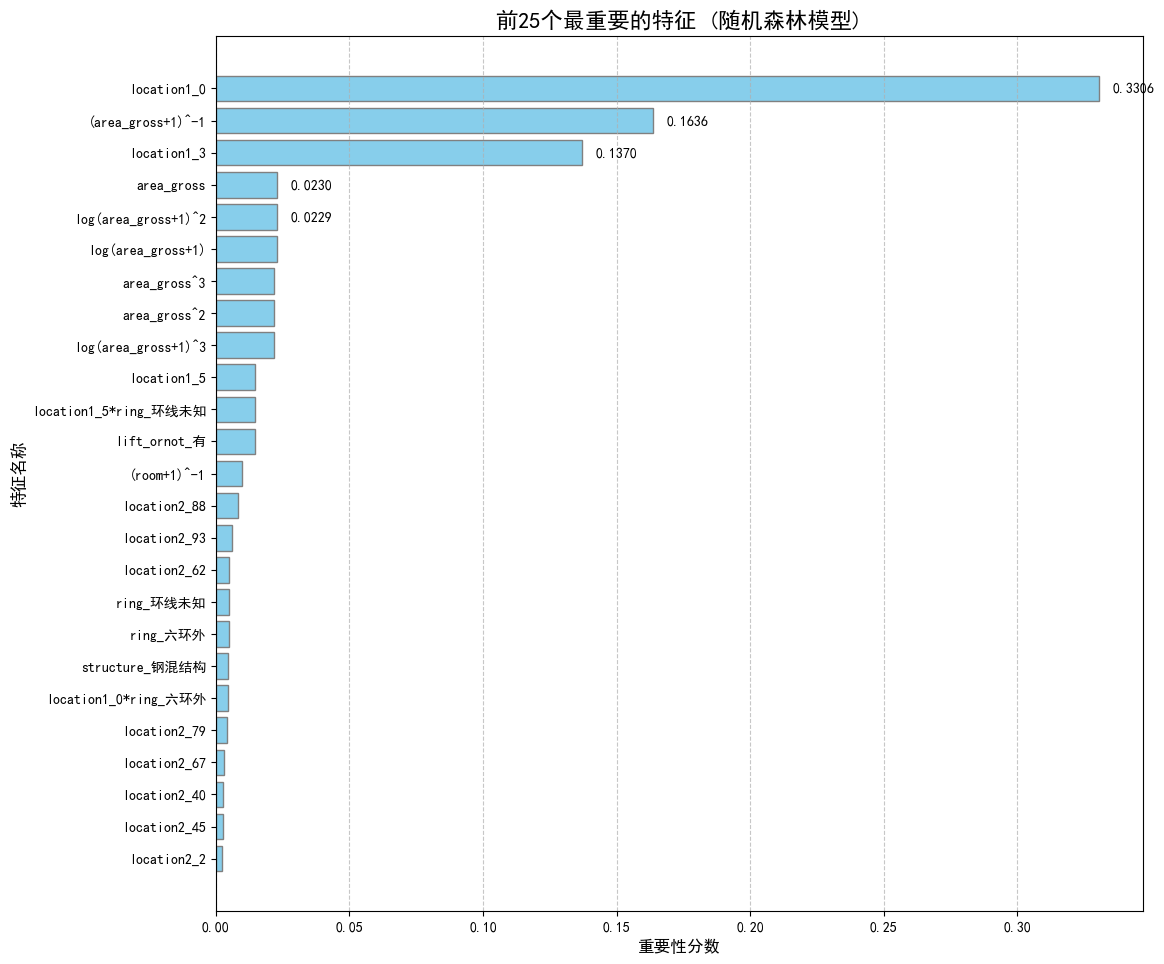

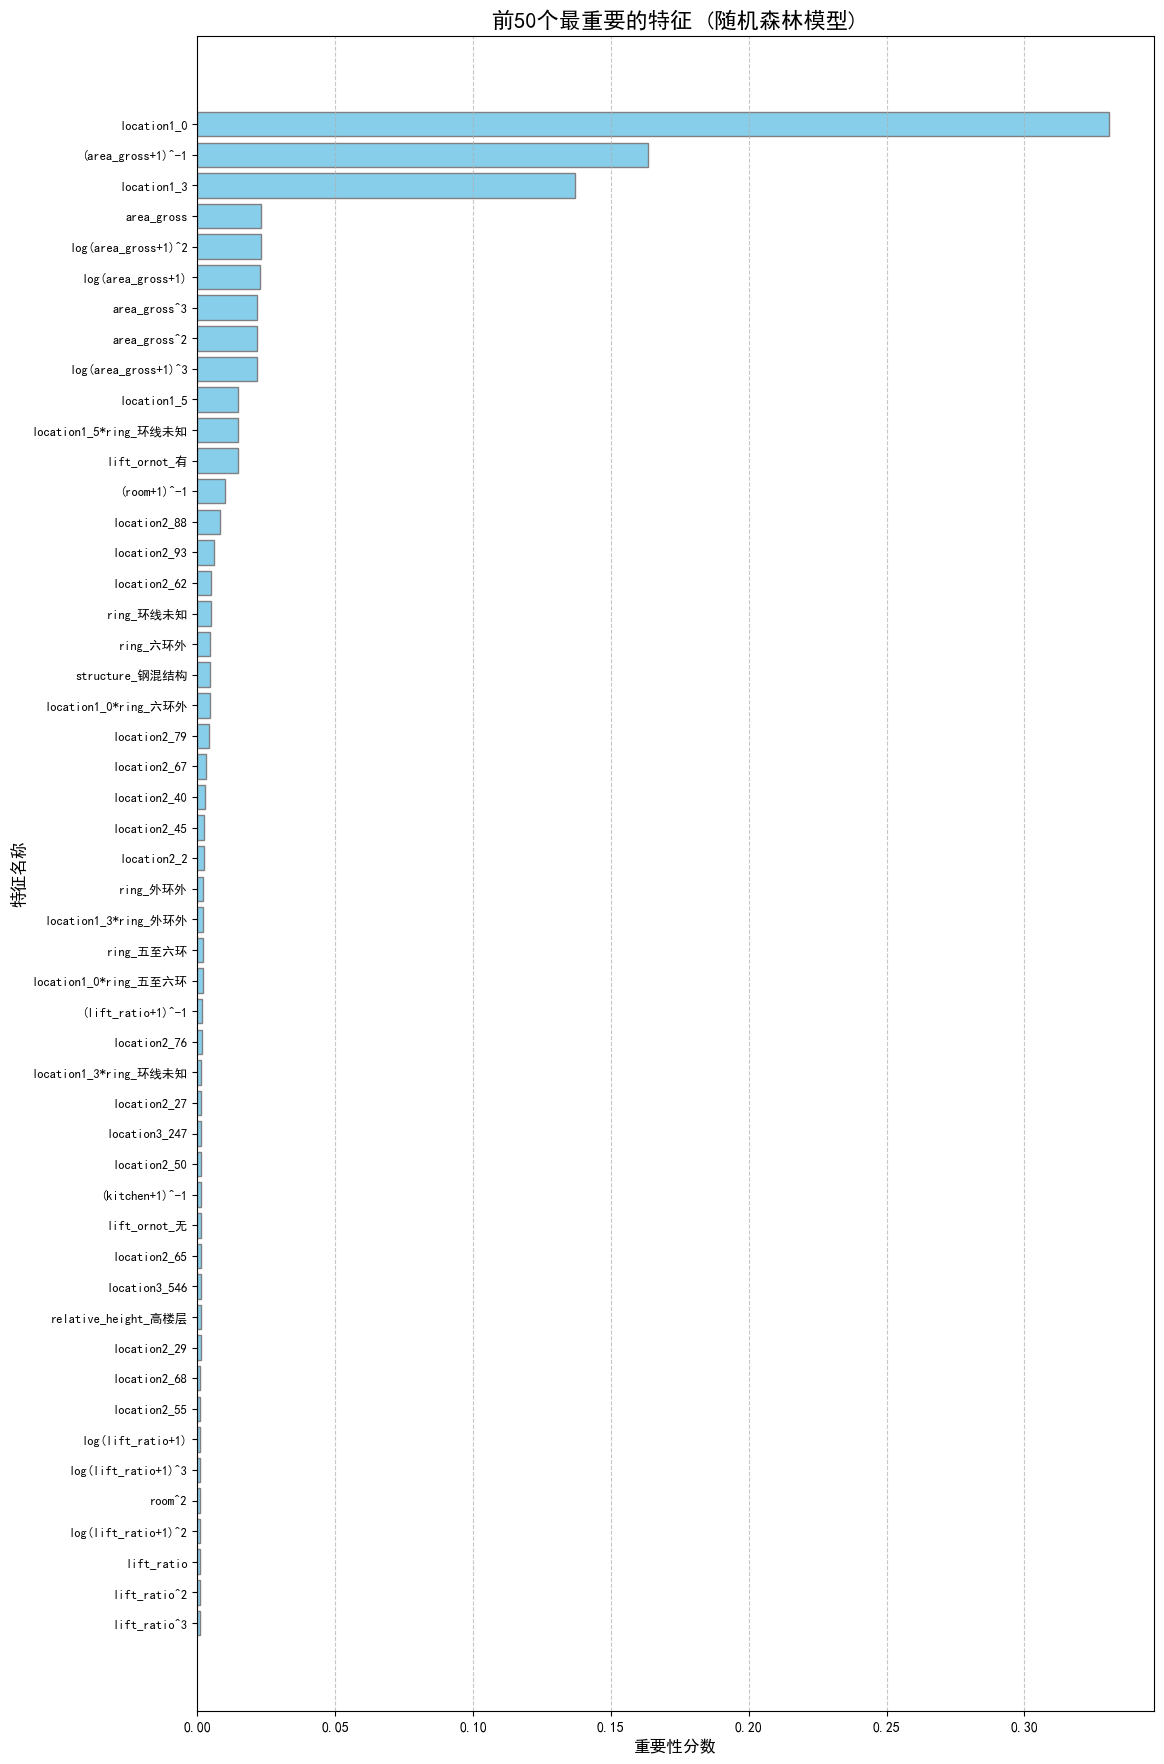

In [8]:
# 重新加载已保存的随机森林模型
RF_model = joblib.load('random_forest_model.joblib')
# 获取随机森林特征重要性
feature_importances = RF_model.feature_importances_

# 创建重要性DataFrame
importance_df = pd.DataFrame({
    'Feature': X_inner.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# 打印前20个最重要特征
print("\n=== 特征重要性排序（前20）===")
print(importance_df.head(20))

# 可视化重要性（显示前25个特征）
plt.figure(figsize=(12, 10))

# 使用Matplotlib直接创建水平条形图
top_25 = importance_df.head(25).sort_values('Importance', ascending=True)
plt.barh(
    y=top_25['Feature'],
    width=top_25['Importance'],
    height=0.8,  # 控制条带高度
    color='skyblue',
    edgecolor='gray'
)

# 为前5个最重要的特征添加数据标签
for i in range(20, 25):  # 仅对前5重要特征添加标签
    plt.text(
        top_25.iloc[i]['Importance'] + 0.005,  # X位置（稍微右移）
        i,                                     # Y位置
        f"{top_25.iloc[i]['Importance']:.4f}", # 格式化为4位小数
        va='center',                           # 垂直居中
        ha='left',                             # 水平左对齐
        fontsize=10
    )

plt.title('前25个最重要的特征 (随机森林模型)', fontsize=16)
plt.xlabel('重要性分数', fontsize=12)
plt.ylabel('特征名称', fontsize=12)

# 设置Y轴刻度标签字体大小
plt.yticks(fontsize=10)

# 优化网格线和布局
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2.0)  # 增加内边距

# 保存高质量图像
plt.savefig('RF_feature_importance.png', dpi=300, bbox_inches='tight')
print("特征重要性图已保存至 RF_feature_importance.png")

# 可选：如果需要更多特征
# 可视化前50个特征（更长的图表）
plt.figure(figsize=(12, 18))
top_50 = importance_df.head(50).sort_values('Importance', ascending=True)
plt.barh(
    y=top_50['Feature'],
    width=top_50['Importance'],
    height=0.8,
    color='skyblue',
    edgecolor='gray'
)

plt.title('前50个最重要的特征 (随机森林模型)', fontsize=16)
plt.xlabel('重要性分数', fontsize=12)
plt.ylabel('特征名称', fontsize=12)
plt.yticks(fontsize=9)  # 较小的字体以适应更多行
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2.0)
plt.savefig('RF_feature_importance_top50.png', dpi=300, bbox_inches='tight')
print("特征重要性图(前50)已保存至 RF_feature_importance_top50.png")

#### RF模型的内存释放

In [ ]:

del RF_model
gc.collect()
print("随机森林模型内存已释放")

### XGBoost模型

#### XGBoost模型的超参调优

In [ ]:
# 创建用于超参数调优的子集
_, X_subset, _, y_subset = train_test_split(
    X_inner, y_inner, test_size=0.99, random_state=100
)
print("子集的特征形状:", X_subset.shape)
print("子集的目标形状:", y_subset.shape)

# 3. 定义Optuna目标函数（使用XGBoost参数）
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'tree_method': 'hist',  # 优化内存使用
        'random_state': 321
    }
    
    model = XGBRegressor(**params, n_jobs=-1)
    score = cross_val_score(model, X_subset, y_subset.values.ravel(), 
                           cv=3, scoring='r2').mean()
    return score

# 4. 运行Optuna调优
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print("最佳超参数:", study.best_params)

# 5. 使用最佳参数训练最终模型
print("\n使用最佳参数在整个训练集上训练模型...")
best_params = study.best_params

# 创建XGBoost模型 - 显式设置每个参数
XGBoost_model = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    min_child_weight=best_params['min_child_weight'],
    tree_method='hist',
    n_jobs=-1,
    random_state=321,
    verbosity=1  # 显示训练进度
)

#### XGBoost模型的模型评价与变量重要性分析

逐步缩小搜索范围，以上超参调优过程作者进行了多次，得到最优参数如下代码所示：

In [26]:
# 直接给出多次调参过程所得到的最优参数，以免重复调参
XGBoost_model = XGBRegressor(
    n_estimators=429,
    max_depth=9,
    learning_rate=0.2793220818731886,
    subsample=0.6939823833898586,
    colsample_bytree=0.7415079269025402,
    gamma=0.008790581037991352,
    min_child_weight=6,
    tree_method='hist',
    n_jobs=-1,
    random_state=321,
    verbosity=1 
)

In [27]:
# 在训练集上训练模型
XGBoost_model.fit(X_train, y_train.values.ravel())

rmse_in_sample = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(XGBoost_model.predict(X_train))))
print("训练集RMSE: ", rmse_in_sample)

rmse_testing = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(XGBoost_model.predict(X_test))))
print("测试集RMSE: ", rmse_testing)

# 在整个内部集上训练模型
XGBoost_model.fit(X_inner, y_inner.values.ravel())
# 立即保存所得到的全样本模型
joblib.dump(XGBoost_model, 'XGBoost_model.joblib')
# 生成外部数据预测结果
predictions = XGBoost_model.predict(X_outer)
pd.DataFrame({
    'ID': range(len(predictions)),
    'Price': np.exp(predictions)  
}).to_csv('XGBoost_outer_predictions.csv', index=False)
rmse_fulldata = np.sqrt(mean_squared_error(np.exp(y_inner), np.exp(XGBoost_model.predict(X_inner))))
print("全内部样本RMSE: ", rmse_fulldata)

# 交叉验证评估
print("\n模型训练完成，进行交叉验证评估...")
rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(np.exp(y_true), np.exp(y_pred))),
    greater_is_better=False
)

full_scores = cross_val_score(
    XGBoost_model, 
    X_inner, 
    y_inner.values.ravel(), 
    cv=3, 
    scoring=rmse_scorer
)

rmse_scores = -full_scores
print(f"全数据集交叉验证RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")

训练集RMSE:  391132.50488046993
测试集RMSE:  755282.4595797269
全内部样本RMSE:  415375.703188236

模型训练完成，进行交叉验证评估...
全数据集交叉验证RMSE: 2204706.4402 ± 1157525.2823


##### XGBoost模型的变量重要性分析与制图


=== 特征重要性排序（前20）===
                     Feature  Importance
47               location1_1  529.792664
39               location1_0  459.914215
60               location1_4  312.369446
54               location1_3  243.382492
69               location1_6  187.937012
68     location1_5*ring_环线未知  185.172867
49               location1_2   85.243057
3919               ring_五至六环   61.520264
67               location1_5   49.503307
109             location2_45   45.362415
44      location1_0*ring_六环外   39.562138
2479        location4_武汉SOHO   39.472515
24         decoration_装修情况未知   31.404049
15              area_gross^2   30.388340
803            location3_803   27.336060
7                     age_新房   25.478897
57    location1_3*ring_内环至中环   22.819042
152             location2_88   22.489368
296            location3_243   22.385706
3927               ring_环线未知   22.163191
自定义特征重要性图已保存至 XGBoost_feature_importance_custom.png
特征重要性图(前50)已保存至 XGBoost_feature_importance_top50.png
多种重要性类型表已保存至 

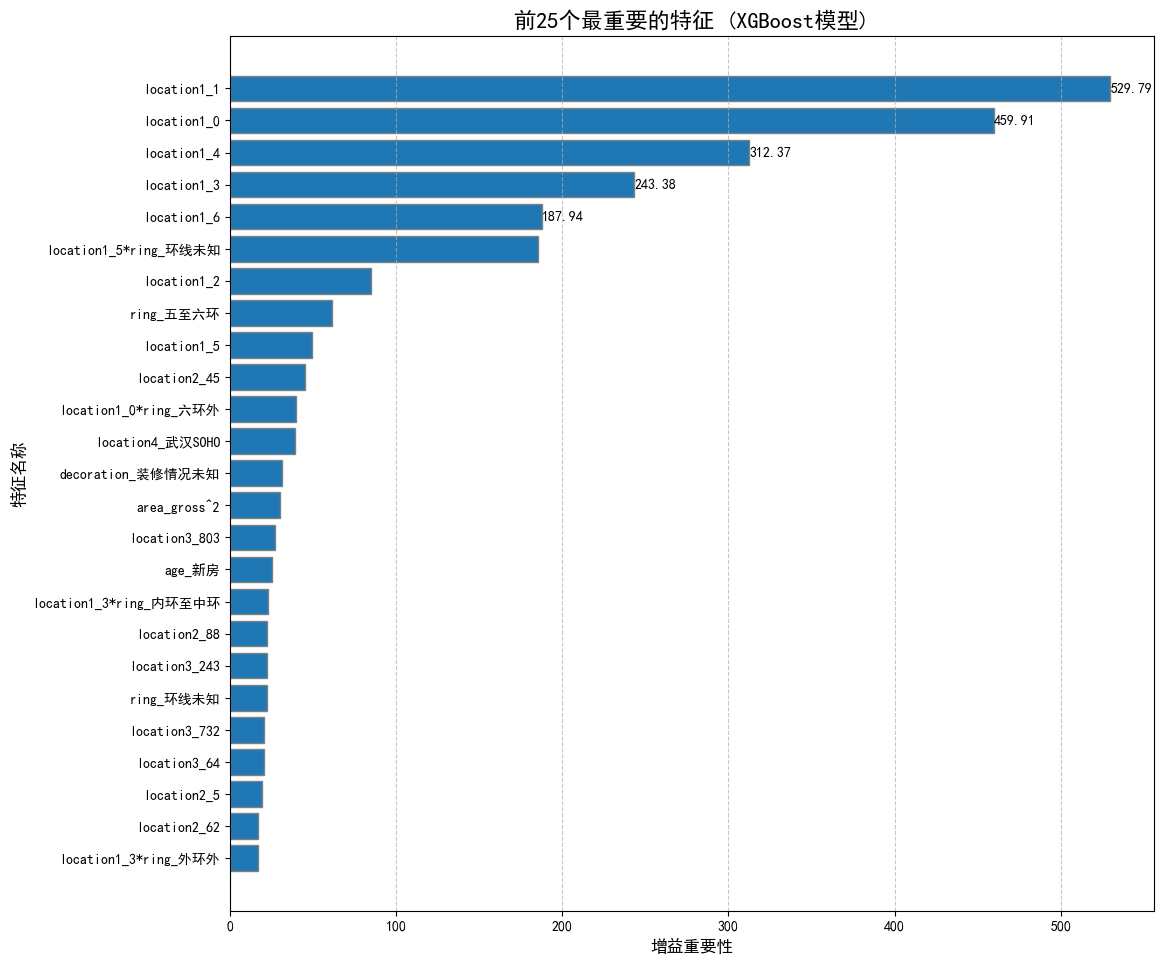

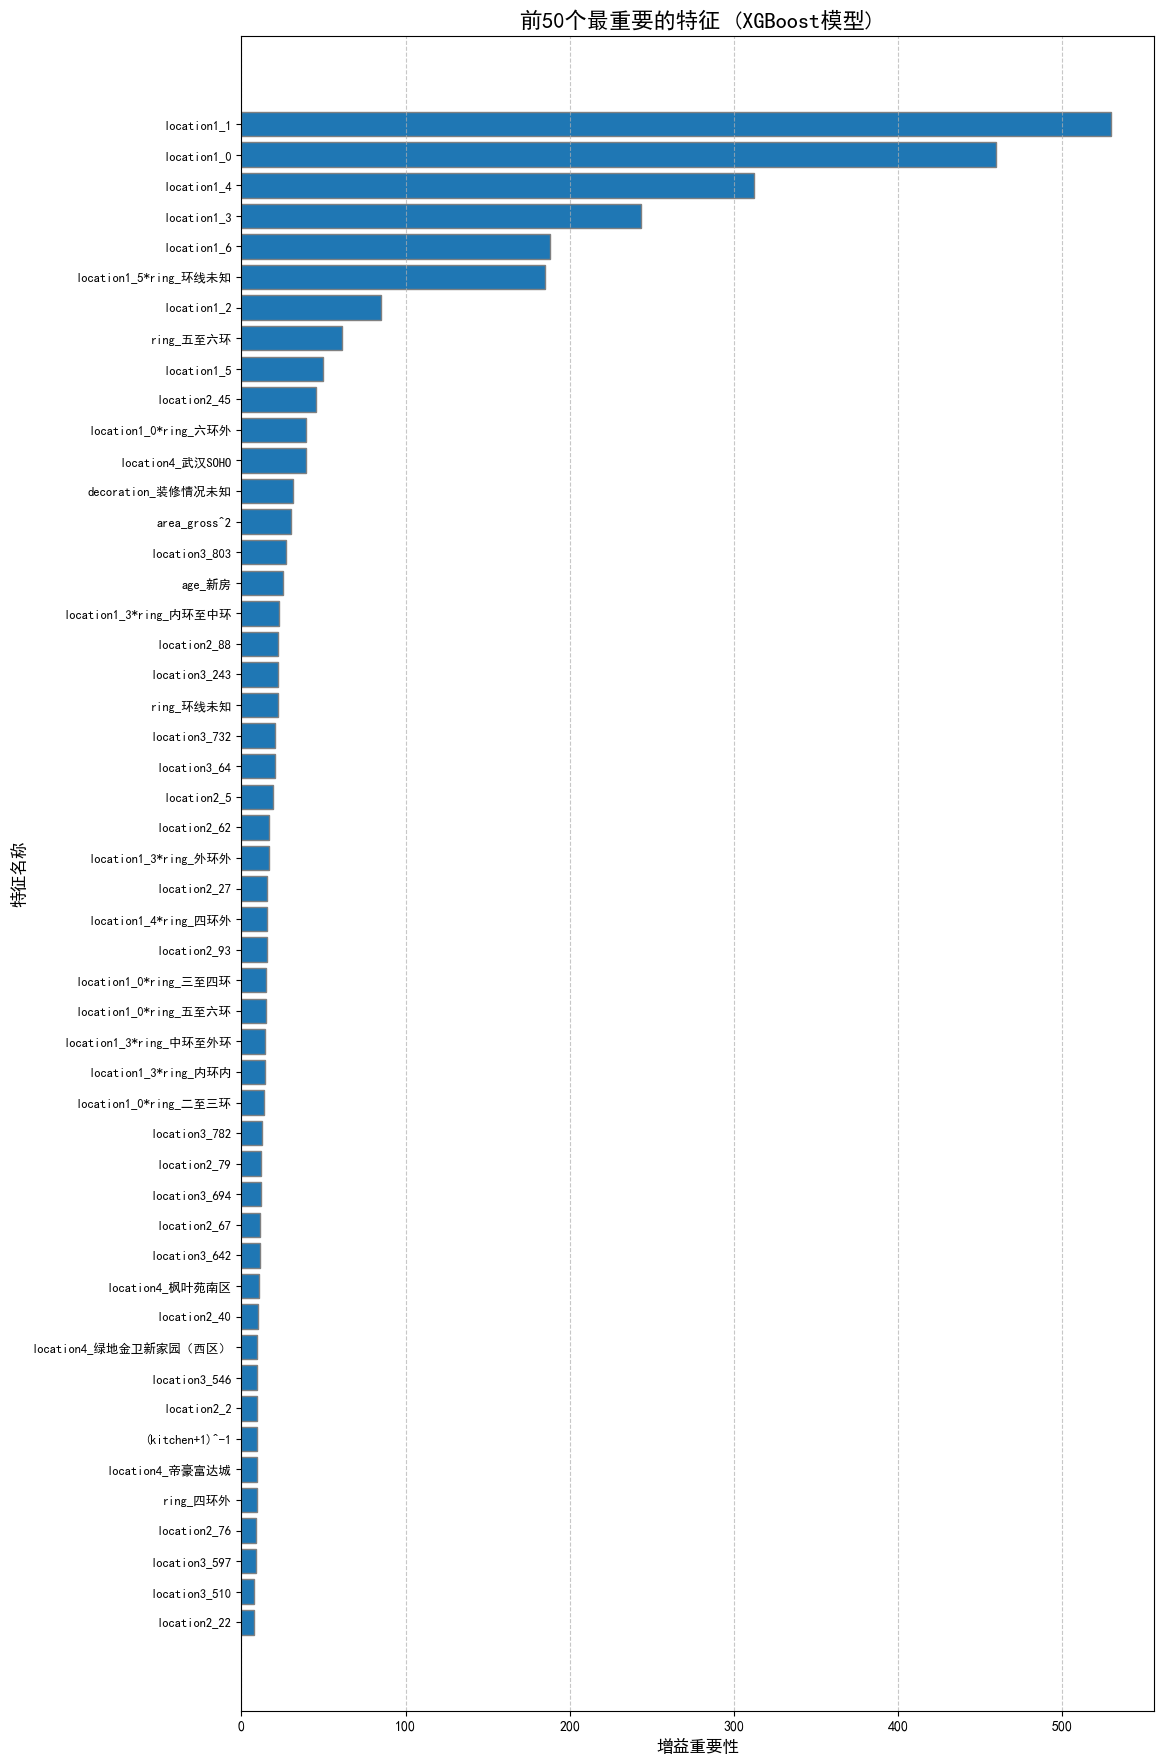

<Figure size 1400x1600 with 0 Axes>

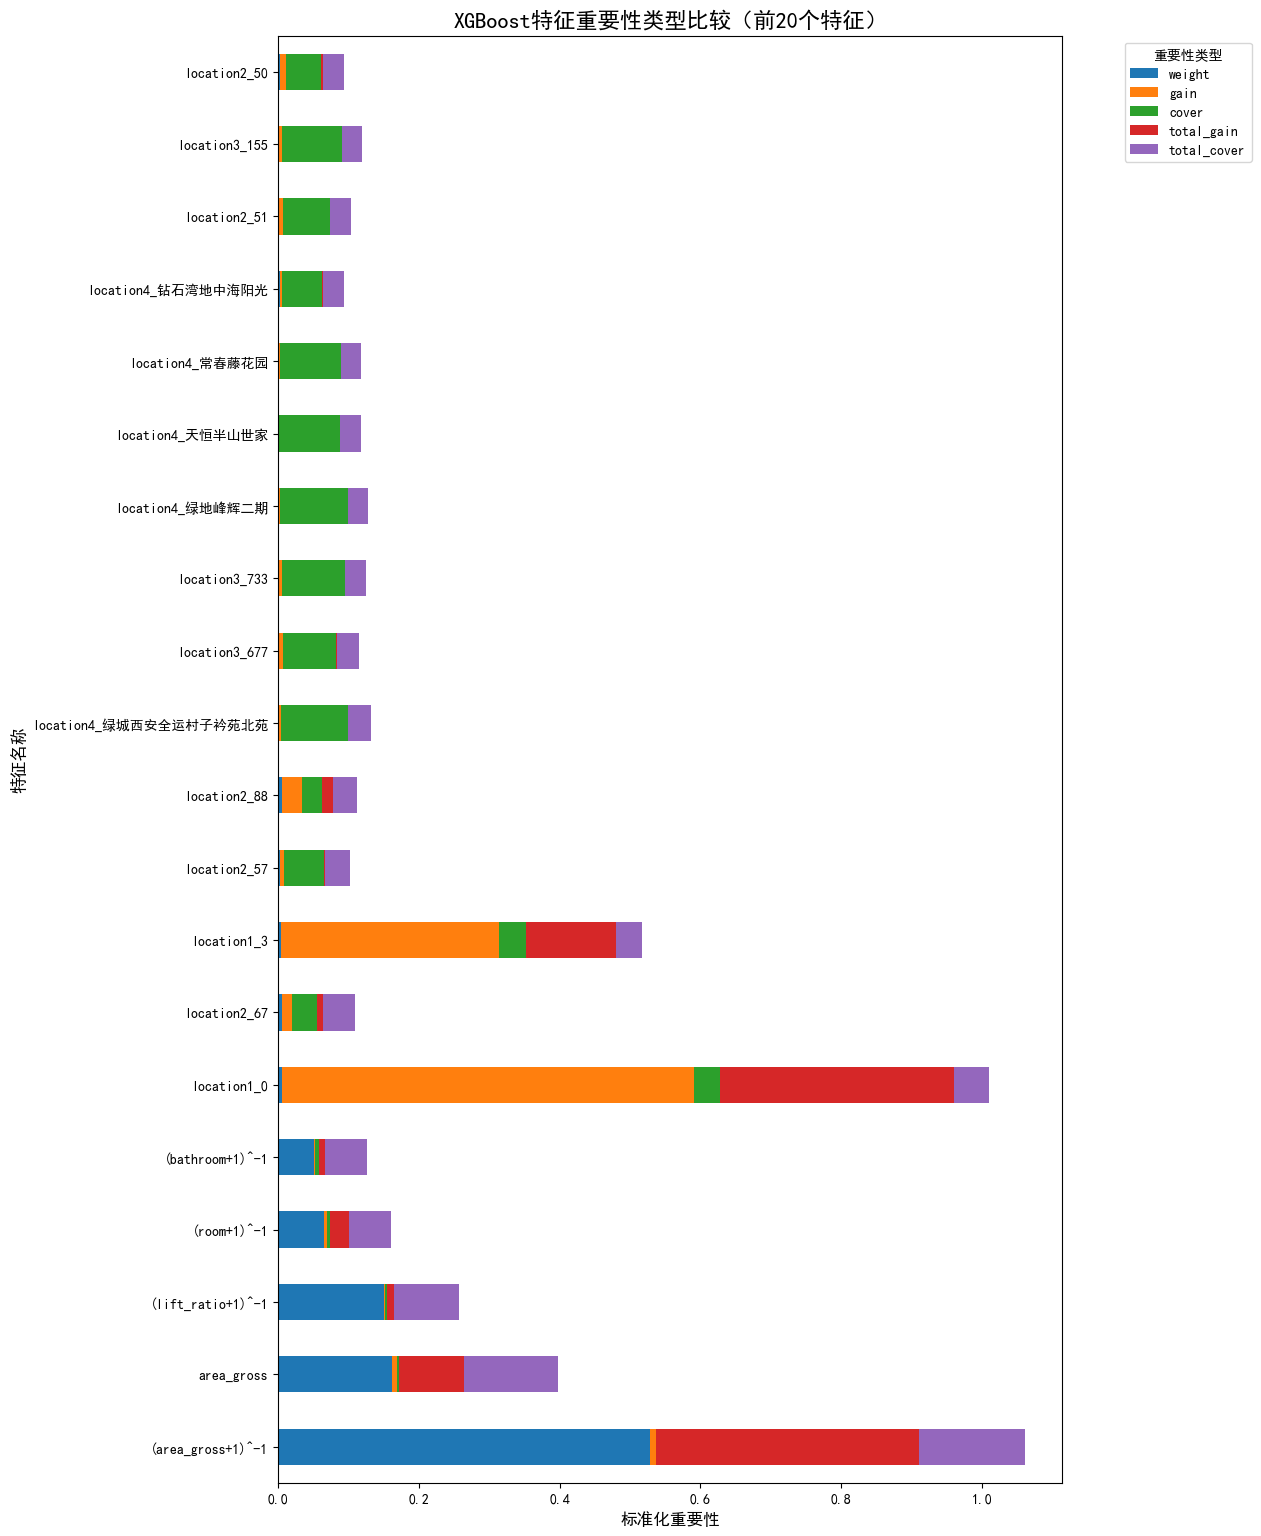

In [ ]:
# 重新加载XGBoost模型
XGBoost_model = joblib.load('XGBoost_model.joblib')

# 获取XGBoost特征重要性（基于增益）
feature_importances = XGBoost_model.get_booster().get_score(importance_type='gain')

# 获取所有特征名称
feature_names = X_inner.columns

# 创建重要性DataFrame（包含所有特征）
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': [feature_importances.get(f, 0) for f in feature_names]  # 处理缺失特征
}).sort_values('Importance', ascending=False)

# 打印前20个最重要特征
print("\n=== 特征重要性排序（前20）===")
print(importance_df.head(20))

# 选择前25个最重要的特征

plt.figure(figsize=(12, 10))
top_25 = importance_df.head(25).sort_values('Importance', ascending=True)

# 手动创建水平条形图
plt.barh(
    y=top_25['Feature'],
    width=top_25['Importance'],
    height=0.8,
    color='#1f77b4',  # 深蓝色
    edgecolor='gray'
)

# 为前几个特征添加数据标签
for i in range(20, 25):  # 只给前5个最重要的添加标签
    importance = top_25.iloc[i]['Importance']
    plt.text(
        importance + 0.005,  # X位置（稍微右移）
        i,                  # Y位置
        f"{importance:.2f}",# 格式化为2位小数
        va='center',        # 垂直居中
        ha='left',          # 水平左对齐
        fontsize=10
    )

# 添加标题和标签
plt.title('前25个最重要的特征 (XGBoost模型)', fontsize=16)
plt.xlabel('增益重要性', fontsize=12)
plt.ylabel('特征名称', fontsize=12)

# 设置Y轴刻度标签字体大小
plt.yticks(fontsize=10)

# 优化网格线和布局
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2.0)

# 保存高质量图像
plt.savefig('XGBoost_feature_importance_custom.png', dpi=300, bbox_inches='tight')
print("自定义特征重要性图已保存至 XGBoost_feature_importance_custom.png")

# 前50个特征的可视化
plt.figure(figsize=(12, 18))
top_50 = importance_df.head(50).sort_values('Importance', ascending=True)
plt.barh(
    y=top_50['Feature'],
    width=top_50['Importance'],
    height=0.8,
    color='#1f77b4',  # 深蓝色
    edgecolor='gray'
)

plt.title('前50个最重要的特征 (XGBoost模型)', fontsize=16)
plt.xlabel('增益重要性', fontsize=12)
plt.ylabel('特征名称', fontsize=12)
plt.yticks(fontsize=9)  # 较小的字体以适应更多行
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2.0)
plt.savefig('XGBoost_feature_importance_top50.png', dpi=300, bbox_inches='tight')
print("特征重要性图(前50)已保存至 XGBoost_feature_importance_top50.png")

# 多种重要性类型比较
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

# 创建包含所有重要性类型的DataFrame
multi_importance_df = pd.DataFrame(index=feature_names)

for imp_type in importance_types:
    scores = XGBoost_model.get_booster().get_score(importance_type=imp_type)
    multi_importance_df[imp_type] = [scores.get(f, 0) for f in feature_names]

# 排序（按平均重要性）
multi_importance_df['Average'] = multi_importance_df.mean(axis=1)
multi_importance_df.sort_values('Average', ascending=False, inplace=True)

# 保存多种重要性类型
multi_importance_df.head(20).to_csv('XGBoost_feature_importance_types.csv')
print("多种重要性类型表已保存至 XGBoost_feature_importance_types.csv")

# 可视化多种重要性类型
plt.figure(figsize=(14, 16))
top_20_multi = multi_importance_df.head(20)

# 标准化重要性
top_20_normalized = top_20_multi.div(top_20_multi.sum(axis=0), axis=1)

# 创建水平堆叠条形图
ax = top_20_normalized[importance_types].plot.barh(
    stacked=True,
    figsize=(14, 16),
    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
)

plt.title('XGBoost特征重要性类型比较（前20个特征）', fontsize=16)
plt.xlabel('标准化重要性', fontsize=12)
plt.ylabel('特征名称', fontsize=12)
plt.legend(title='重要性类型', loc='upper right', bbox_to_anchor=(1.25, 1.0))
plt.tight_layout(pad=3.0)
plt.savefig('XGBoost_feature_importance_comparison.png', dpi=300, bbox_inches='tight')
print("特征重要性类型比较图已保存至 XGBoost_feature_importance_comparison.png")

#### XGBoost模型的内存释放

In [19]:
del XGBoost_model
gc.collect()
print("XGBoost模型内存已释放")

XGBoost模型内存已释放


### LightGBM模型

#### LightGBM模型的参数调优 

一个较为意外的结果是：在LightGBM的最优超参搜索过程中，调优子集的规模subsetsize会极大地影响最优超参的表现。而且该影响是非线性的，经过网格搜索可以发现subsetsize=0.2时预测集的预测效果是最好的。

In [ ]:
# 生成result_list以储存网格搜索的结果
result_list=[]
for k in range(2):
    # 接下来呈现的是搜索的最后一步(0.175-0.2之间的3分搜索)，之前已经进行过多步更大范围精读更粗的搜索
    subsetsize=0.175+0.025*((k+1)/3)
    this_result=[]
    _, X_subset, _, y_subset = train_test_split(
        X_inner, y_inner, test_size=subsetsize, random_state=520
    )
    print(f"调优子集形状: {X_subset.shape}")

    # 3. 改进的Optuna目标函数
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1e-1, log=True),
            'min_child_samples': trial.suggest_int('min_child_samples', 2, 10),
            'num_leaves': trial.suggest_int('num_leaves', 10, 80),
            'random_state': 321,
            'n_jobs': -1
        }

        model = LGBMRegressor(**params)
        # 使用更大验证折数（5折）
        score = cross_val_score(model, X_subset, y_subset.values.ravel(),
                            cv=5, scoring='r2').mean()
        return score

    # 4. 运行Optuna（增加试验次数）
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50, timeout=13600)  # 1小时超时
    this_result.append(study.best_params)
    print(f"最佳参数: {study.best_params}")

    # 5. 使用最佳参数训练最终模型
    print("\n使用最佳参数在整个训练集上训练模型...")
    best_params = study.best_params

    LightGBM_model = LGBMRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        learning_rate=best_params['learning_rate'],
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        reg_alpha=best_params['reg_alpha'],
        reg_lambda=best_params['reg_lambda'],
        min_child_samples=best_params['min_child_samples'],
        random_state=321,
        n_jobs=-1
    )

    # 在训练集上训练模型
    LightGBM_model.fit(X_train, y_train.values.ravel())
    
    rmse_in_sample = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(LightGBM_model.predict(X_train))))
    this_result.append(rmse_in_sample)
    print("训练集 RMSE: ", rmse_in_sample)

    rmse_testing = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(LightGBM_model.predict(X_test))))
    this_result.append(rmse_testing)
    print("测试集 RMSE: ", rmse_testing)

    # 在整个内部集上训练模型
    LightGBM_model.fit(X_inner, y_inner.values.ravel())
    rmse_fulldata = np.sqrt(mean_squared_error(np.exp(y_inner), np.exp(LightGBM_model.predict(X_inner))))
    this_result.append(rmse_fulldata)
    print("全内部样本 RMSE: ", rmse_fulldata)

    # 7. 交叉验证评估
    print("\n模型训练完成，进行交叉验证评估...")

    rmse_scorer = make_scorer(
        lambda y_true, y_pred: np.sqrt(mean_squared_error(np.exp(y_true), np.exp(y_pred))),
        greater_is_better=False
    )

    full_scores = cross_val_score(
        LightGBM_model,
        X_inner,
        y_inner.values.ravel(),
        cv=3,
        scoring=rmse_scorer
    )

    rmse_scores = -full_scores
    this_result.append((rmse_scores.mean(),rmse_scores.std()))
    print(f"全数据集交叉验证 RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")

    predictions = LightGBM_model.predict(X_outer)

    pd.DataFrame({
        'ID': range(len(predictions)),
        'Price': np.exp(predictions)
    }).to_csv('LightGBM_outer_predictions_subsetsize='+str(subsetsize)+'.csv', index=False)
    result_list.append(this_result)

接下来呈现网格搜索的结果：

In [ ]:
for k in range(len(result_list)):
    print(result_list[k])

#### LightGBM模型的模型评价与变量重要性分析

经过多次复杂的双层（subsetsize一层，optuna一层）范围逐渐缩小的超参搜索，最优超参如下：

In [22]:
LightGBM_model = LGBMRegressor(
    n_estimators= 419,
        max_depth=15,
        learning_rate=0.22597483460023596,
        subsample=0.6441398468305728,
        colsample_bytree=0.9617373206508942,
        reg_alpha=0.009090924487188424,
        reg_lambda=0.010259585508734638,
        min_child_samples=4,
        random_state=321,
        n_jobs=-1
)

##### 模型训练

In [25]:
# 在训练集上训练模型
LightGBM_model.fit(X_train, y_train.values.ravel())

rmse_in_sample = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(LightGBM_model.predict(X_train))))
print("训练集RMSE: ", rmse_in_sample)

rmse_testing = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(LightGBM_model.predict(X_test))))
print("测试集RMSE: ", rmse_testing)

# 在整个内部集上训练模型
LightGBM_model.fit(X_inner, y_inner.values.ravel())
# 立即保存所得到的全样本模型
joblib.dump(LightGBM_model, 'LightGBM_model.joblib')
# 生成外部数据预测结果
predictions = LightGBM_model.predict(X_outer)
pd.DataFrame({
    'ID': range(len(predictions)),
    'Price': np.exp(predictions)  
}).to_csv('LightGBM_outer_predictions.csv', index=False)
rmse_fulldata = np.sqrt(mean_squared_error(np.exp(y_inner), np.exp(LightGBM_model.predict(X_inner))))
print("全内部样本RMSE: ", rmse_fulldata)

# 交叉验证评估
print("\n模型训练完成，进行交叉验证评估...")
rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(np.exp(y_true), np.exp(y_pred))),
    greater_is_better=False
)

full_scores = cross_val_score(
    LightGBM_model, 
    X_inner, 
    y_inner.values.ravel(), 
    cv=3, 
    scoring=rmse_scorer
)

rmse_scores = -full_scores
print(f"全数据集交叉验证RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8632
[LightGBM] [Info] Number of data points in the train set: 67306, number of used features: 2832
[LightGBM] [Info] Start training from score 14.047816
训练集RMSE:  411971.1297957898
测试集RMSE:  708913.0775192996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9002
[LightGBM] [Info] Number of data points in the train set: 84133, number of used features: 2982
[LightGBM] [Info] Start training from score 14.048802
全内部样本RMSE:  430043.81586301717

模型训练完成，进行交叉验证评估...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044171 seconds.
You can set `force_col_wise=true` t

##### LightGBM模型的重要性分析与制图

In [ ]:
# 获取CatBoost特征重要性 - 主要使用默认类型
feature_importances = CatBoost_model.get_feature_importance()
feature_names = X_inner.columns

# 创建重要性DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# 打印前20个最重要特征
print("\n=== 特征重要性排序（前20）===")
print(importance_df.head(20))

# 绘制前25特征图表
plt.figure(figsize=(12, 10))
top_25 = importance_df.head(25).sort_values('Importance', ascending=True)
plt.barh(y=top_25['Feature'], width=top_25['Importance'], height=0.8, color='#1f77b4')
plt.title('前25个最重要的特征 (CatBoost模型)', fontsize=16)
plt.xlabel('特征重要性', fontsize=12)
plt.ylabel('特征名称', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2.0)
plt.savefig('CatBoost_feature_importance_top25.png', dpi=300)
print("特征重要性图(前25)已保存")

# 绘制前50特征图表
plt.figure(figsize=(12, 18))
top_50 = importance_df.head(50).sort_values('Importance', ascending=True)
plt.barh(y=top_50['Feature'], width=top_50['Importance'], height=0.8, color='#1f77b4')
plt.title('前50个最重要的特征 (CatBoost模型)', fontsize=16)
plt.xlabel('特征重要性', fontsize=12)
plt.ylabel('特征名称', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2.0)
plt.savefig('CatBoost_feature_importance_top50.png', dpi=300)
print("特征重要性图(前50)已保存")

# 多种重要性类型比较 - 修正版本
print("\n=== 多种重要性类型比较 ===")

# 只使用两种不同的重要性类型
importance_types = ['PredictionValuesChange', 'LossFunctionChange']
type_names = ['预测值变化', '损失函数变化']  # 中文标签

# 创建包含所有重要性类型的DataFrame
multi_importance_df = pd.DataFrame({'Feature': feature_names})

# 创建测试池
test_pool = Pool(X_test, y_test.values.ravel())

# 获取每种重要性类型
for imp_type in importance_types:
    try:
        if imp_type == 'LossFunctionChange':
            scores = CatBoost_model.get_feature_importance(test_pool, type=imp_type)
        else:
            scores = CatBoost_model.get_feature_importance(type=imp_type)
            
        multi_importance_df[imp_type] = scores
        print(f"已计算 {imp_type} 重要性")
    except Exception as e:
        print(f"无法计算 {imp_type} 重要性: {str(e)}")
        multi_importance_df[imp_type] = 0  # 使用0作为占位符

# 标准化每种重要性类型（除以各自的总和）
for imp_type in importance_types:
    total = multi_importance_df[imp_type].sum()
    if total > 0:  # 避免除以0
        multi_importance_df[imp_type] = multi_importance_df[imp_type] / total

# 计算综合重要性（标准化后相加）
multi_importance_df['Combined'] = multi_importance_df[importance_types].sum(axis=1)
multi_importance_df.sort_values('Combined', ascending=False, inplace=True)

# 保存多种重要性类型
multi_importance_df.head(20).to_csv('CatBoost_feature_importance_types.csv')
print("多种重要性类型表已保存")

# 可视化多种重要性类型（标准化后堆叠）
plt.figure(figsize=(14, 16))
top_20_multi = multi_importance_df.head(20).sort_values('Combined', ascending=True)

# 创建水平堆叠条形图
ax = top_20_multi.plot.barh(
    x='Feature',
    y=importance_types,
    stacked=True,
    figsize=(14, 16),
    color=['#3498db', '#e74c3c']  # 蓝色表示预测值变化，红色表示损失函数变化
)

plt.title('CatBoost特征重要性类型比较（前20个特征）', fontsize=16)
plt.xlabel('标准化重要性', fontsize=12)
plt.ylabel('特征名称', fontsize=12)
plt.legend(title='重要性类型', labels=type_names, loc='upper right', bbox_to_anchor=(1.25, 1.0))
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout(pad=3.0)
plt.savefig('CatBoost_feature_importance_comparison.png', dpi=300, bbox_inches='tight')
print("特征重要性类型比较图已保存")

# 可选：绘制综合重要性的水平条形图
plt.figure(figsize=(12, 10))
top_20_combined = top_20_multi.sort_values('Combined', ascending=True)
plt.barh(
    y=top_20_combined['Feature'],
    width=top_20_combined['Combined'],
    height=0.8,
    color='#2ecc71'  # 绿色表示综合重要性
)

# 添加数据标签
for i, (_, row) in enumerate(top_20_combined.iterrows()):
    plt.text(
        row['Combined'] + 0.005,
        i,
        f"{row['Combined']:.3f}",
        va='center',
        fontsize=9
    )

plt.title('综合特征重要性 (CatBoost模型)', fontsize=16)
plt.xlabel('综合重要性', fontsize=12)
plt.ylabel('特征名称', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('CatBoost_combined_feature_importance.png', dpi=300, bbox_inches='tight')
print("综合特征重要性图已保存")


=== LightGBM特征重要性排序（前20）===
                        Feature  Importance
1             (area_gross+1)^-1        1656
14                   area_gross         533
5             (lift_ratio+1)^-1         531
2               (bathroom+1)^-1         207
6                   (room+1)^-1         200
34                 lift_ornot_有         162
33                 lift_ornot_无         126
23                decoration_精装         110
3907        relative_height_低楼层         101
3911        relative_height_高楼层         101
36                   lift_ratio          91
3943             structure_钢混结构          71
3974                  year_2021          68
20                decoration_其他          61
3975                  year_2022          59
3                   (hall+1)^-1          56
3906        relative_height_中楼层          56
22                decoration_简装          53
3950  transaction_ownership_商品房          50
3931                    south_0          49
自定义特征重要性图已保存至 LightGBM_feature_importance_custo

#### LightGBM 模型的内存释放

In [32]:
del LightGBM_model
gc.collect()
print("XGBoost模型内存已释放")

XGBoost模型内存已释放


### CatBoost模型

#### CatBoost模型的参数调优

In [5]:
# 使用最大比例的子集调优（99.99%）
_,X_subset,_,y_subset = train_test_split(
    X_inner, y_inner, test_size=0.9999, random_state=20250603
)
print(f"调优子集形状: {X_subset.shape}")

# Optuna目标调优
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 1200, 1800),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.19, 0.4, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-1, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.5, 1.5),
        'random_strength': trial.suggest_float('random_strength', 1e-7, 1e-3, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 30, 100),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'verbose': False,
        'random_seed': 321,
        'task_type': 'CPU', 
        'od_type': 'Iter',   
        'od_wait': 50,      
    }

    # 创建Pool对象
    cv_data = Pool(
        data=X_subset, 
        label=y_subset.values.ravel()
    )
    
    # 使用CatBoost内置交叉验证
    cv_results = cv(
        pool=cv_data,
        params=params,
        fold_count=5,
        shuffle=True,
        partition_random_seed=321,
        verbose=False
    )
    
    # 获取最小的RMSE
    rmse_score = cv_results['test-RMSE-mean'].min()
    return rmse_score

# 运行Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=10800)  # 3小时超时

# 使用最佳参数训练最终模型
print("\n使用最佳参数在整个训练集上训练模型...")
best_params = study.best_params

# 创建CatBoost特定参数
final_params = {
    'iterations': 3000,
    'depth': best_params['depth'],
    'learning_rate': best_params['learning_rate'],
    'l2_leaf_reg': best_params['l2_leaf_reg'],
    'bagging_temperature': best_params['bagging_temperature'],
    'random_strength': best_params['random_strength'],
    'min_data_in_leaf': best_params['min_data_in_leaf'],
    'grow_policy': best_params['grow_policy'],
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': 321,
    'od_type': 'Iter',  
    'od_wait': 50,     
    'task_type': 'CPU',
    'verbose': 100
}

CatBoost_model = CatBoostRegressor(**final_params)

[I 2025-06-03 16:21:55,379] A new study created in memory with name: no-name-486e63a6-d4f6-4f24-865d-2d6d72055beb


调优子集形状: (84125, 3976)
Training on fold [0/5]

bestTest = 0.1479508101
bestIteration = 1473

Training on fold [1/5]

bestTest = 0.1654949234
bestIteration = 1473

Training on fold [2/5]

bestTest = 0.1548186143
bestIteration = 1473

Training on fold [3/5]

bestTest = 0.1505834417
bestIteration = 1472

Training on fold [4/5]


[I 2025-06-03 16:25:26,301] Trial 0 finished with value: 0.15567721817655142 and parameters: {'iterations': 1474, 'depth': 9, 'learning_rate': 0.28043527877407687, 'l2_leaf_reg': 8.028123636571372, 'bagging_temperature': 0.890420401429682, 'random_strength': 0.00022182228879786086, 'min_data_in_leaf': 38, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.15567721817655142.



bestTest = 0.1595317157
bestIteration = 1473

Training on fold [0/5]

bestTest = 0.1353803429
bestIteration = 1568

Training on fold [1/5]

bestTest = 0.1350158328
bestIteration = 1568

Training on fold [2/5]

bestTest = 0.1333781394
bestIteration = 1568

Training on fold [3/5]

bestTest = 0.1300037849
bestIteration = 1568

Training on fold [4/5]


[I 2025-06-03 16:26:40,806] Trial 1 finished with value: 0.1337948508946078 and parameters: {'iterations': 1569, 'depth': 4, 'learning_rate': 0.24188793106849873, 'l2_leaf_reg': 1.0437610103049428, 'bagging_temperature': 1.4297453704748582, 'random_strength': 3.3757808514935513e-06, 'min_data_in_leaf': 94, 'grow_policy': 'SymmetricTree'}. Best is trial 1 with value: 0.1337948508946078.



bestTest = 0.1351961545
bestIteration = 1568

Training on fold [0/5]

bestTest = 0.1452791712
bestIteration = 1554

Training on fold [1/5]

bestTest = 0.1483665996
bestIteration = 1554

Training on fold [2/5]

bestTest = 0.1492680368
bestIteration = 1554

Training on fold [3/5]

bestTest = 0.1435588464
bestIteration = 1552

Training on fold [4/5]


[I 2025-06-03 16:30:16,895] Trial 2 finished with value: 0.14770019796325012 and parameters: {'iterations': 1555, 'depth': 9, 'learning_rate': 0.2525064999516948, 'l2_leaf_reg': 9.540462312730153, 'bagging_temperature': 1.1615221350899465, 'random_strength': 1.6866974812386663e-06, 'min_data_in_leaf': 98, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.1337948508946078.



bestTest = 0.1520266688
bestIteration = 1553

Training on fold [0/5]

bestTest = 0.1288386278
bestIteration = 1722

Training on fold [1/5]

bestTest = 0.1262659809
bestIteration = 1726

Training on fold [2/5]

bestTest = 0.1246706215
bestIteration = 1722

Training on fold [3/5]

bestTest = 0.1302377268
bestIteration = 1723

Training on fold [4/5]


[I 2025-06-03 16:33:56,386] Trial 3 finished with value: 0.12751984619576007 and parameters: {'iterations': 1727, 'depth': 8, 'learning_rate': 0.2684002431025558, 'l2_leaf_reg': 0.20257314373199145, 'bagging_temperature': 1.4741990022190026, 'random_strength': 0.0007852195704301765, 'min_data_in_leaf': 44, 'grow_policy': 'Depthwise'}. Best is trial 3 with value: 0.12751984619576007.



bestTest = 0.1275683271
bestIteration = 1726

Training on fold [0/5]

bestTest = 0.1396299021
bestIteration = 1253

Training on fold [1/5]

bestTest = 0.1404372751
bestIteration = 1252

Training on fold [2/5]

bestTest = 0.1377661823
bestIteration = 1253

Training on fold [3/5]

bestTest = 0.1364803515
bestIteration = 1253

Training on fold [4/5]


[I 2025-06-03 16:36:00,014] Trial 4 finished with value: 0.13842794408578601 and parameters: {'iterations': 1254, 'depth': 6, 'learning_rate': 0.21154044752402182, 'l2_leaf_reg': 2.077322540119408, 'bagging_temperature': 1.2428635970611022, 'random_strength': 0.0005910763023314652, 'min_data_in_leaf': 96, 'grow_policy': 'Depthwise'}. Best is trial 3 with value: 0.12751984619576007.



bestTest = 0.1378260021
bestIteration = 1253

Training on fold [0/5]

bestTest = 0.1364023763
bestIteration = 1561

Training on fold [1/5]

bestTest = 0.1411300186
bestIteration = 1561

Training on fold [2/5]

bestTest = 0.138095345
bestIteration = 1561

Training on fold [3/5]

bestTest = 0.133238624
bestIteration = 1561

Training on fold [4/5]


[I 2025-06-03 16:38:54,560] Trial 5 finished with value: 0.13766855528737407 and parameters: {'iterations': 1562, 'depth': 7, 'learning_rate': 0.24424485532497964, 'l2_leaf_reg': 4.3257795827308785, 'bagging_temperature': 0.647850384053499, 'random_strength': 0.00024375390554701827, 'min_data_in_leaf': 100, 'grow_policy': 'Depthwise'}. Best is trial 3 with value: 0.12751984619576007.



bestTest = 0.1394764125
bestIteration = 1561

Training on fold [0/5]

bestTest = 0.129632092
bestIteration = 1613

Training on fold [1/5]

bestTest = 0.1283403272
bestIteration = 1613

Training on fold [2/5]

bestTest = 0.1262342849
bestIteration = 1613

Training on fold [3/5]

bestTest = 0.1258330081
bestIteration = 1613

Training on fold [4/5]


[I 2025-06-03 16:41:52,649] Trial 6 finished with value: 0.12772629728888946 and parameters: {'iterations': 1614, 'depth': 7, 'learning_rate': 0.23640440445106253, 'l2_leaf_reg': 0.14117918650672923, 'bagging_temperature': 0.7644422381267433, 'random_strength': 4.0433303733069683e-07, 'min_data_in_leaf': 67, 'grow_policy': 'Depthwise'}. Best is trial 3 with value: 0.12751984619576007.



bestTest = 0.1285917742
bestIteration = 1613

Training on fold [0/5]

bestTest = 0.139495502
bestIteration = 1643

Training on fold [1/5]

bestTest = 0.1430943917
bestIteration = 1642

Training on fold [2/5]

bestTest = 0.1391947944
bestIteration = 1643

Training on fold [3/5]

bestTest = 0.1325860977
bestIteration = 1643

Training on fold [4/5]


[I 2025-06-03 16:45:11,776] Trial 7 finished with value: 0.13836978187623136 and parameters: {'iterations': 1644, 'depth': 8, 'learning_rate': 0.33255786842248874, 'l2_leaf_reg': 6.398745224619531, 'bagging_temperature': 1.05520628490382, 'random_strength': 2.4259536187601964e-05, 'min_data_in_leaf': 97, 'grow_policy': 'Depthwise'}. Best is trial 3 with value: 0.12751984619576007.



bestTest = 0.1374756971
bestIteration = 1643

Training on fold [0/5]

bestTest = 0.1351347299
bestIteration = 1675

Training on fold [1/5]

bestTest = 0.1348658184
bestIteration = 1675

Training on fold [2/5]

bestTest = 0.1332716483
bestIteration = 1675

Training on fold [3/5]

bestTest = 0.1312699448
bestIteration = 1675

Training on fold [4/5]


[I 2025-06-03 16:46:31,144] Trial 8 finished with value: 0.13401867396261882 and parameters: {'iterations': 1676, 'depth': 4, 'learning_rate': 0.21337617162873954, 'l2_leaf_reg': 0.5215561662410058, 'bagging_temperature': 0.7575568849453133, 'random_strength': 0.00012532824095244058, 'min_data_in_leaf': 35, 'grow_policy': 'SymmetricTree'}. Best is trial 3 with value: 0.12751984619576007.



bestTest = 0.1355512285
bestIteration = 1675

Training on fold [0/5]

bestTest = 0.1312566251
bestIteration = 1438

Training on fold [1/5]

bestTest = 0.1295063455
bestIteration = 1438

Training on fold [2/5]

bestTest = 0.1282368139
bestIteration = 1438

Training on fold [3/5]

bestTest = 0.1267703854
bestIteration = 1437

Training on fold [4/5]


[I 2025-06-03 16:48:45,050] Trial 9 finished with value: 0.12932131214345538 and parameters: {'iterations': 1439, 'depth': 6, 'learning_rate': 0.3109383473656813, 'l2_leaf_reg': 0.11778201534654731, 'bagging_temperature': 0.5533117420651856, 'random_strength': 4.9133410948995086e-06, 'min_data_in_leaf': 75, 'grow_policy': 'Depthwise'}. Best is trial 3 with value: 0.12751984619576007.



bestTest = 0.1308349336
bestIteration = 1438

Training on fold [0/5]

bestTest = 0.1299389709
bestIteration = 1448

Training on fold [1/5]

bestTest = 0.139986986
bestIteration = 1173

Training on fold [2/5]

bestTest = 0.1355666752
bestIteration = 1263

Training on fold [3/5]

bestTest = 0.1252091024
bestIteration = 1260

Training on fold [4/5]


[I 2025-06-03 16:56:54,649] Trial 10 finished with value: 0.13582089528090693 and parameters: {'iterations': 1791, 'depth': 10, 'learning_rate': 0.35257494155965036, 'l2_leaf_reg': 0.34541359912073394, 'bagging_temperature': 1.4414814483126877, 'random_strength': 3.650301371359397e-05, 'min_data_in_leaf': 49, 'grow_policy': 'SymmetricTree'}. Best is trial 3 with value: 0.12751984619576007.



bestTest = 0.1481930133
bestIteration = 1106

Training on fold [0/5]

bestTest = 0.127837288
bestIteration = 1787

Training on fold [1/5]

bestTest = 0.1257882959
bestIteration = 1424

Training on fold [2/5]

bestTest = 0.1260104947
bestIteration = 1788

Training on fold [3/5]

bestTest = 0.1227172867
bestIteration = 1788

Training on fold [4/5]


[I 2025-06-03 17:00:03,428] Trial 11 finished with value: 0.12562973804573538 and parameters: {'iterations': 1789, 'depth': 7, 'learning_rate': 0.3935336614347702, 'l2_leaf_reg': 0.12782820412907003, 'bagging_temperature': 0.8998141196814677, 'random_strength': 1.147231248397054e-07, 'min_data_in_leaf': 60, 'grow_policy': 'Depthwise'}. Best is trial 11 with value: 0.12562973804573538.



bestTest = 0.1257356152
bestIteration = 1777

Training on fold [0/5]

bestTest = 0.1274431808
bestIteration = 1797

Training on fold [1/5]

bestTest = 0.1254116305
bestIteration = 1792

Training on fold [2/5]

bestTest = 0.1272723869
bestIteration = 1619

Training on fold [3/5]

bestTest = 0.1229536532
bestIteration = 1795

Training on fold [4/5]


[I 2025-06-03 17:03:44,069] Trial 12 finished with value: 0.12588185188201365 and parameters: {'iterations': 1799, 'depth': 8, 'learning_rate': 0.3815538645545566, 'l2_leaf_reg': 0.24733209225905478, 'bagging_temperature': 0.9425503556562249, 'random_strength': 1.0714377829109613e-07, 'min_data_in_leaf': 49, 'grow_policy': 'Depthwise'}. Best is trial 11 with value: 0.12562973804573538.



bestTest = 0.1262506793
bestIteration = 1798

Training on fold [0/5]

bestTest = 0.127742346
bestIteration = 1705

Training on fold [1/5]

bestTest = 0.1265184396
bestIteration = 1791

Training on fold [2/5]

bestTest = 0.1265130785
bestIteration = 1793

Training on fold [3/5]

bestTest = 0.1233667018
bestIteration = 1795

Training on fold [4/5]


[I 2025-06-03 17:06:36,120] Trial 13 finished with value: 0.12638574720887213 and parameters: {'iterations': 1797, 'depth': 6, 'learning_rate': 0.3969061962958438, 'l2_leaf_reg': 0.32053177095753443, 'bagging_temperature': 0.9450125505501954, 'random_strength': 1.1222636063299203e-07, 'min_data_in_leaf': 56, 'grow_policy': 'Depthwise'}. Best is trial 11 with value: 0.12562973804573538.



bestTest = 0.1277476628
bestIteration = 1796

Training on fold [0/5]

bestTest = 0.1269555668
bestIteration = 1374

Training on fold [1/5]

bestTest = 0.133536991
bestIteration = 1373

Training on fold [2/5]

bestTest = 0.1307709274
bestIteration = 1283

Training on fold [3/5]

bestTest = 0.1220388913
bestIteration = 1377

Training on fold [4/5]


[I 2025-06-03 17:09:27,740] Trial 14 finished with value: 0.13129490757632686 and parameters: {'iterations': 1383, 'depth': 8, 'learning_rate': 0.3989253616116442, 'l2_leaf_reg': 0.7085998783914528, 'bagging_temperature': 0.8310121284422356, 'random_strength': 1.049808816811787e-07, 'min_data_in_leaf': 60, 'grow_policy': 'SymmetricTree'}. Best is trial 11 with value: 0.12562973804573538.



bestTest = 0.1431080308
bestIteration = 1381

Training on fold [0/5]

bestTest = 0.1310526579
bestIteration = 1723

Training on fold [1/5]

bestTest = 0.1283223931
bestIteration = 1725

Training on fold [2/5]

bestTest = 0.1295295404
bestIteration = 1724

Training on fold [3/5]

bestTest = 0.1248353162
bestIteration = 1725

Training on fold [4/5]


[I 2025-06-03 17:11:43,555] Trial 15 finished with value: 0.1285674638941838 and parameters: {'iterations': 1726, 'depth': 5, 'learning_rate': 0.36038819078018275, 'l2_leaf_reg': 0.2570545481694297, 'bagging_temperature': 1.058936873861673, 'random_strength': 6.551521637312045e-07, 'min_data_in_leaf': 78, 'grow_policy': 'Depthwise'}. Best is trial 11 with value: 0.12562973804573538.



bestTest = 0.1290747
bestIteration = 1716

Training on fold [0/5]

bestTest = 0.1275033128
bestIteration = 1720

Training on fold [1/5]

bestTest = 0.1263995119
bestIteration = 1373

Training on fold [2/5]

bestTest = 0.1257604944
bestIteration = 1421

Training on fold [3/5]

bestTest = 0.1223543336
bestIteration = 1717

Training on fold [4/5]


[I 2025-06-03 17:15:55,430] Trial 16 finished with value: 0.12558157970507372 and parameters: {'iterations': 1721, 'depth': 10, 'learning_rate': 0.30585605933258964, 'l2_leaf_reg': 0.12538303041621815, 'bagging_temperature': 1.2370931854583485, 'random_strength': 4.0938620433672126e-07, 'min_data_in_leaf': 50, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.12558157970507372.



bestTest = 0.1257703408
bestIteration = 1720

Training on fold [0/5]

bestTest = 0.1309136014
bestIteration = 1703

Training on fold [1/5]

bestTest = 0.1259685983
bestIteration = 1712

Training on fold [2/5]

bestTest = 0.1294454666
bestIteration = 1698

Training on fold [3/5]

bestTest = 0.1229064442
bestIteration = 1711

Training on fold [4/5]


[I 2025-06-03 17:20:13,097] Trial 17 finished with value: 0.12754588250196658 and parameters: {'iterations': 1713, 'depth': 10, 'learning_rate': 0.3067312065431394, 'l2_leaf_reg': 1.3844375962124391, 'bagging_temperature': 1.2854575602108795, 'random_strength': 3.1941146819103447e-07, 'min_data_in_leaf': 68, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.12558157970507372.



bestTest = 0.1284795678
bestIteration = 1712

Training on fold [0/5]

bestTest = 0.1291126781
bestIteration = 1221

Training on fold [1/5]

bestTest = 0.1368964867
bestIteration = 1223

Training on fold [2/5]

bestTest = 0.1293892011
bestIteration = 1222

Training on fold [3/5]

bestTest = 0.120785522
bestIteration = 1223

Training on fold [4/5]


[I 2025-06-03 17:24:05,880] Trial 18 finished with value: 0.13243867721989486 and parameters: {'iterations': 1224, 'depth': 9, 'learning_rate': 0.2981538751748343, 'l2_leaf_reg': 0.14279171745014588, 'bagging_temperature': 1.1727520147209045, 'random_strength': 1.380365027939776e-06, 'min_data_in_leaf': 30, 'grow_policy': 'SymmetricTree'}. Best is trial 16 with value: 0.12558157970507372.



bestTest = 0.145999774
bestIteration = 1221

Training on fold [0/5]

bestTest = 0.1322149029
bestIteration = 1694

Training on fold [1/5]

bestTest = 0.1298292034
bestIteration = 1695

Training on fold [2/5]

bestTest = 0.129015715
bestIteration = 1695

Training on fold [3/5]

bestTest = 0.1253483793
bestIteration = 1694

Training on fold [4/5]


[I 2025-06-03 17:26:17,115] Trial 19 finished with value: 0.12940130449775972 and parameters: {'iterations': 1696, 'depth': 5, 'learning_rate': 0.3303276039000424, 'l2_leaf_reg': 0.10129441902975667, 'bagging_temperature': 1.2722235664580412, 'random_strength': 3.599167848574526e-07, 'min_data_in_leaf': 85, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.12558157970507372.



bestTest = 0.1305881063
bestIteration = 1695

Training on fold [0/5]

bestTest = 0.1301059243
bestIteration = 1375

Training on fold [1/5]

bestTest = 0.128095434
bestIteration = 1375

Training on fold [2/5]

bestTest = 0.1275415623
bestIteration = 1375

Training on fold [3/5]

bestTest = 0.1258876286
bestIteration = 1375

Training on fold [4/5]


[I 2025-06-03 17:28:46,675] Trial 20 finished with value: 0.1280195947917453 and parameters: {'iterations': 1376, 'depth': 7, 'learning_rate': 0.2830833906198836, 'l2_leaf_reg': 0.45500438232342305, 'bagging_temperature': 1.068164518807959, 'random_strength': 9.243755567328478e-06, 'min_data_in_leaf': 58, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.12558157970507372.



bestTest = 0.1284605307
bestIteration = 1366

Training on fold [0/5]

bestTest = 0.1334421898
bestIteration = 1471

Training on fold [1/5]

bestTest = 0.1281114925
bestIteration = 896

Training on fold [2/5]

bestTest = 0.1259696407
bestIteration = 1453

Training on fold [3/5]

bestTest = 0.1231394717
bestIteration = 1400

Training on fold [4/5]


[I 2025-06-03 17:32:32,299] Trial 21 finished with value: 0.12742101814788215 and parameters: {'iterations': 1800, 'depth': 10, 'learning_rate': 0.3681447923721221, 'l2_leaf_reg': 0.20150650653102675, 'bagging_temperature': 0.9778511940517269, 'random_strength': 1.8211859840309646e-07, 'min_data_in_leaf': 49, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.12558157970507372.



bestTest = 0.126230218
bestIteration = 1793

Training on fold [0/5]

bestTest = 0.1284823991
bestIteration = 1718

Training on fold [1/5]

bestTest = 0.1260344872
bestIteration = 1752

Training on fold [2/5]

bestTest = 0.1251855536
bestIteration = 1748

Training on fold [3/5]

bestTest = 0.1234088993
bestIteration = 1747

Training on fold [4/5]


[I 2025-06-03 17:36:09,861] Trial 22 finished with value: 0.12586393573870464 and parameters: {'iterations': 1753, 'depth': 8, 'learning_rate': 0.3794391383609952, 'l2_leaf_reg': 0.18923396680860952, 'bagging_temperature': 0.8992232283550826, 'random_strength': 1.063717997071344e-06, 'min_data_in_leaf': 50, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.12558157970507372.



bestTest = 0.1261617352
bestIteration = 1750

Training on fold [0/5]

bestTest = 0.1279758511
bestIteration = 1525

Training on fold [1/5]

bestTest = 0.126164995
bestIteration = 1739

Training on fold [2/5]

bestTest = 0.1255747599
bestIteration = 1353

Training on fold [3/5]

bestTest = 0.1214652132
bestIteration = 1734

Training on fold [4/5]


[I 2025-06-03 17:39:52,784] Trial 23 finished with value: 0.12519373170733467 and parameters: {'iterations': 1745, 'depth': 9, 'learning_rate': 0.3367195640616337, 'l2_leaf_reg': 0.1715516986006811, 'bagging_temperature': 0.7991940416245731, 'random_strength': 9.70947020777268e-07, 'min_data_in_leaf': 55, 'grow_policy': 'Depthwise'}. Best is trial 23 with value: 0.12519373170733467.



bestTest = 0.124655937
bestIteration = 1744

Training on fold [0/5]

bestTest = 0.1300146401
bestIteration = 1190

Training on fold [1/5]

bestTest = 0.1263991666
bestIteration = 1380

Training on fold [2/5]

bestTest = 0.1247994366
bestIteration = 1649

Training on fold [3/5]

bestTest = 0.1221309756
bestIteration = 1640

Training on fold [4/5]


[I 2025-06-03 17:43:19,845] Trial 24 finished with value: 0.12568856358007224 and parameters: {'iterations': 1651, 'depth': 9, 'learning_rate': 0.33689166618009186, 'l2_leaf_reg': 0.10064280757168516, 'bagging_temperature': 0.6796911695360417, 'random_strength': 7.87577334194487e-07, 'min_data_in_leaf': 61, 'grow_policy': 'Depthwise'}. Best is trial 23 with value: 0.12519373170733467.



bestTest = 0.1249566961
bestIteration = 1649

Training on fold [0/5]

bestTest = 0.1275738925
bestIteration = 1310

Training on fold [1/5]

bestTest = 0.1253253841
bestIteration = 1595

Training on fold [2/5]

bestTest = 0.1260642288
bestIteration = 1552

Training on fold [3/5]

bestTest = 0.1222780772
bestIteration = 1535

Training on fold [4/5]


[I 2025-06-03 17:47:19,652] Trial 25 finished with value: 0.1253952691827906 and parameters: {'iterations': 1607, 'depth': 10, 'learning_rate': 0.3182334680498526, 'l2_leaf_reg': 0.15922218973414, 'bagging_temperature': 0.8131735522228362, 'random_strength': 3.123800593901082e-06, 'min_data_in_leaf': 42, 'grow_policy': 'Depthwise'}. Best is trial 23 with value: 0.12519373170733467.



bestTest = 0.1255602138
bestIteration = 1605

Training on fold [0/5]

bestTest = 0.1289262449
bestIteration = 1506

Training on fold [1/5]

bestTest = 0.1409827664
bestIteration = 1549

Training on fold [2/5]

bestTest = 0.1321605728
bestIteration = 1438

Training on fold [3/5]

bestTest = 0.1217139906
bestIteration = 1519

Training on fold [4/5]


[I 2025-06-03 17:57:00,839] Trial 26 finished with value: 0.13472371778361555 and parameters: {'iterations': 1619, 'depth': 10, 'learning_rate': 0.3169196088771062, 'l2_leaf_reg': 0.47557053443787645, 'bagging_temperature': 0.5181656893003905, 'random_strength': 2.876279335228022e-06, 'min_data_in_leaf': 41, 'grow_policy': 'SymmetricTree'}. Best is trial 23 with value: 0.12519373170733467.



bestTest = 0.1496178315
bestIteration = 1603

Training on fold [0/5]

bestTest = 0.1339305023
bestIteration = 1594

Training on fold [1/5]

bestTest = 0.1358921964
bestIteration = 1594

Training on fold [2/5]

bestTest = 0.1296339116
bestIteration = 1594

Training on fold [3/5]

bestTest = 0.1365120786
bestIteration = 1593

Training on fold [4/5]


[I 2025-06-03 18:01:01,324] Trial 27 finished with value: 0.13385088514202126 and parameters: {'iterations': 1595, 'depth': 10, 'learning_rate': 0.2940823874381199, 'l2_leaf_reg': 2.358426528453506, 'bagging_temperature': 0.7572599834412238, 'random_strength': 9.244291037888964e-06, 'min_data_in_leaf': 44, 'grow_policy': 'Depthwise'}. Best is trial 23 with value: 0.12519373170733467.



bestTest = 0.1332748914
bestIteration = 1594

Training on fold [0/5]

bestTest = 0.1266035309
bestIteration = 1668

Training on fold [1/5]

bestTest = 0.1253824205
bestIteration = 1667

Training on fold [2/5]

bestTest = 0.1246091901
bestIteration = 1668

Training on fold [3/5]

bestTest = 0.1219674792
bestIteration = 1668

Training on fold [4/5]


[I 2025-06-03 18:04:48,787] Trial 28 finished with value: 0.12461153531217659 and parameters: {'iterations': 1669, 'depth': 9, 'learning_rate': 0.26651387253940473, 'l2_leaf_reg': 0.1740817668072709, 'bagging_temperature': 0.5983961869272761, 'random_strength': 2.153069706438594e-06, 'min_data_in_leaf': 53, 'grow_policy': 'Depthwise'}. Best is trial 28 with value: 0.12461153531217659.



bestTest = 0.1244948148
bestIteration = 1668

Training on fold [0/5]

bestTest = 0.1294840706
bestIteration = 1522

Training on fold [1/5]

bestTest = 0.1308867948
bestIteration = 1523

Training on fold [2/5]

bestTest = 0.1281058125
bestIteration = 1523

Training on fold [3/5]

bestTest = 0.1229734156
bestIteration = 1523

Training on fold [4/5]


[I 2025-06-03 18:08:21,335] Trial 29 finished with value: 0.12748915518596596 and parameters: {'iterations': 1524, 'depth': 9, 'learning_rate': 0.27468215985223576, 'l2_leaf_reg': 0.688585299893985, 'bagging_temperature': 0.6179815224492761, 'random_strength': 1.98719706011407e-05, 'min_data_in_leaf': 36, 'grow_policy': 'Depthwise'}. Best is trial 28 with value: 0.12461153531217659.



bestTest = 0.1259929008
bestIteration = 1523

Training on fold [0/5]

bestTest = 0.129415395
bestIteration = 1472

Training on fold [1/5]

bestTest = 0.1255324628
bestIteration = 1472

Training on fold [2/5]

bestTest = 0.1262734412
bestIteration = 1471

Training on fold [3/5]

bestTest = 0.1227371678
bestIteration = 1469

Training on fold [4/5]


[I 2025-06-03 18:12:03,642] Trial 30 finished with value: 0.12597727271803663 and parameters: {'iterations': 1473, 'depth': 9, 'learning_rate': 0.2606468371610372, 'l2_leaf_reg': 0.33556601229085536, 'bagging_temperature': 0.7085517842302957, 'random_strength': 2.419586401720021e-06, 'min_data_in_leaf': 53, 'grow_policy': 'Depthwise'}. Best is trial 28 with value: 0.12461153531217659.



bestTest = 0.1259165429
bestIteration = 1472

Training on fold [0/5]

bestTest = 0.1273994722
bestIteration = 1577

Training on fold [1/5]

bestTest = 0.1252575538
bestIteration = 1673

Training on fold [2/5]

bestTest = 0.1243504829
bestIteration = 1673

Training on fold [3/5]

bestTest = 0.1217757906
bestIteration = 1665

Training on fold [4/5]


[I 2025-06-03 18:16:30,203] Trial 31 finished with value: 0.12528923361234645 and parameters: {'iterations': 1674, 'depth': 10, 'learning_rate': 0.28519087727829745, 'l2_leaf_reg': 0.16963686984950826, 'bagging_temperature': 0.58663200499128, 'random_strength': 6.283595532818234e-06, 'min_data_in_leaf': 42, 'grow_policy': 'Depthwise'}. Best is trial 28 with value: 0.12461153531217659.



bestTest = 0.127633538
bestIteration = 1669

Training on fold [0/5]

bestTest = 0.1286685436
bestIteration = 1666

Training on fold [1/5]

bestTest = 0.1252648331
bestIteration = 1667

Training on fold [2/5]

bestTest = 0.1240986868
bestIteration = 1667

Training on fold [3/5]

bestTest = 0.1221567146
bestIteration = 1667

Training on fold [4/5]


[I 2025-06-03 18:20:25,502] Trial 32 finished with value: 0.12523956308926537 and parameters: {'iterations': 1668, 'depth': 9, 'learning_rate': 0.28619264543024087, 'l2_leaf_reg': 0.17160990245258625, 'bagging_temperature': 0.5766844188571413, 'random_strength': 4.329612699931894e-06, 'min_data_in_leaf': 42, 'grow_policy': 'Depthwise'}. Best is trial 28 with value: 0.12461153531217659.



bestTest = 0.1260017693
bestIteration = 1666

Training on fold [0/5]

bestTest = 0.1260223569
bestIteration = 1665

Training on fold [1/5]

bestTest = 0.1263930619
bestIteration = 1666

Training on fold [2/5]

bestTest = 0.1278509918
bestIteration = 1662

Training on fold [3/5]

bestTest = 0.1234706403
bestIteration = 1666

Training on fold [4/5]


[I 2025-06-03 18:24:25,106] Trial 33 finished with value: 0.12634182593022833 and parameters: {'iterations': 1667, 'depth': 9, 'learning_rate': 0.23090449671170216, 'l2_leaf_reg': 0.26221841482925234, 'bagging_temperature': 0.5879841936038841, 'random_strength': 5.253311521330438e-06, 'min_data_in_leaf': 39, 'grow_policy': 'Depthwise'}. Best is trial 28 with value: 0.12461153531217659.



bestTest = 0.1279572523
bestIteration = 1663

Training on fold [0/5]

bestTest = 0.1271315156
bestIteration = 1747

Training on fold [1/5]

bestTest = 0.1259146
bestIteration = 1750

Training on fold [2/5]

bestTest = 0.1235404461
bestIteration = 1750

Training on fold [3/5]

bestTest = 0.1214256173
bestIteration = 1747

Training on fold [4/5]


[I 2025-06-03 18:28:47,272] Trial 34 finished with value: 0.124567835273416 and parameters: {'iterations': 1751, 'depth': 9, 'learning_rate': 0.19104176664498201, 'l2_leaf_reg': 0.18298473331498136, 'bagging_temperature': 0.5000014322760711, 'random_strength': 6.007782995088355e-06, 'min_data_in_leaf': 30, 'grow_policy': 'Depthwise'}. Best is trial 34 with value: 0.124567835273416.



bestTest = 0.1248129859
bestIteration = 1745

Training on fold [0/5]

bestTest = 0.1273564168
bestIteration = 1739

Training on fold [1/5]

bestTest = 0.1241257815
bestIteration = 1743

Training on fold [2/5]

bestTest = 0.1238035914
bestIteration = 1743

Training on fold [3/5]

bestTest = 0.1232585621
bestIteration = 1743

Training on fold [4/5]


[I 2025-06-03 18:33:05,012] Trial 35 finished with value: 0.12463845731061665 and parameters: {'iterations': 1744, 'depth': 9, 'learning_rate': 0.19204522911986177, 'l2_leaf_reg': 0.23614849216838898, 'bagging_temperature': 0.5413855422520938, 'random_strength': 1.8576571710602272e-06, 'min_data_in_leaf': 31, 'grow_policy': 'Depthwise'}. Best is trial 34 with value: 0.124567835273416.



bestTest = 0.1246444527
bestIteration = 1743

Training on fold [0/5]

bestTest = 0.1264874189
bestIteration = 1753

Training on fold [1/5]

bestTest = 0.1267619614
bestIteration = 1753

Training on fold [2/5]

bestTest = 0.1250331732
bestIteration = 1753

Training on fold [3/5]

bestTest = 0.1252120064
bestIteration = 1746

Training on fold [4/5]


[I 2025-06-03 18:36:39,467] Trial 36 finished with value: 0.1274477805116508 and parameters: {'iterations': 1754, 'depth': 8, 'learning_rate': 0.19294603301833674, 'l2_leaf_reg': 0.23165132575048275, 'bagging_temperature': 0.5227925667282822, 'random_strength': 2.0778714302191646e-06, 'min_data_in_leaf': 32, 'grow_policy': 'SymmetricTree'}. Best is trial 34 with value: 0.124567835273416.



bestTest = 0.1337229299
bestIteration = 1749

Training on fold [0/5]

bestTest = 0.1275601909
bestIteration = 1698

Training on fold [1/5]

bestTest = 0.1251141791
bestIteration = 1698

Training on fold [2/5]

bestTest = 0.1249544769
bestIteration = 1694

Training on fold [3/5]

bestTest = 0.1232812605
bestIteration = 1696

Training on fold [4/5]


[I 2025-06-03 18:40:46,321] Trial 37 finished with value: 0.1252970359022009 and parameters: {'iterations': 1699, 'depth': 9, 'learning_rate': 0.19060828464385318, 'l2_leaf_reg': 0.3730391886762639, 'bagging_temperature': 0.6648948060968066, 'random_strength': 1.5128260053104522e-05, 'min_data_in_leaf': 34, 'grow_policy': 'Depthwise'}. Best is trial 34 with value: 0.124567835273416.



bestTest = 0.1255636132
bestIteration = 1698

Training on fold [0/5]

bestTest = 0.1291685819
bestIteration = 1743

Training on fold [1/5]

bestTest = 0.1275153926
bestIteration = 1742

Training on fold [2/5]

bestTest = 0.1259827526
bestIteration = 1743

Training on fold [3/5]

bestTest = 0.1238388568
bestIteration = 1743

Training on fold [4/5]


[I 2025-06-03 18:44:19,439] Trial 38 finished with value: 0.12709594475145244 and parameters: {'iterations': 1744, 'depth': 8, 'learning_rate': 0.20222298546195294, 'l2_leaf_reg': 0.7246680024683145, 'bagging_temperature': 0.5036249863472497, 'random_strength': 1.4779258179442887e-06, 'min_data_in_leaf': 64, 'grow_policy': 'Depthwise'}. Best is trial 34 with value: 0.124567835273416.



bestTest = 0.1289722322
bestIteration = 1738

Training on fold [0/5]

bestTest = 0.128546945
bestIteration = 1755

Training on fold [1/5]

bestTest = 0.1268668751
bestIteration = 1755

Training on fold [2/5]

bestTest = 0.1263420497
bestIteration = 1755

Training on fold [3/5]

bestTest = 0.1235362327
bestIteration = 1755

Training on fold [4/5]


[I 2025-06-03 18:48:20,174] Trial 39 finished with value: 0.12637244211445772 and parameters: {'iterations': 1756, 'depth': 9, 'learning_rate': 0.21843043293771247, 'l2_leaf_reg': 1.2065460234589056, 'bagging_temperature': 0.7131708635005977, 'random_strength': 7.707201040602036e-07, 'min_data_in_leaf': 71, 'grow_policy': 'Depthwise'}. Best is trial 34 with value: 0.124567835273416.



bestTest = 0.126570108
bestIteration = 1755

Training on fold [0/5]

bestTest = 0.1300627048
bestIteration = 1546

Training on fold [1/5]

bestTest = 0.1285519433
bestIteration = 1546

Training on fold [2/5]

bestTest = 0.1262657781
bestIteration = 1546

Training on fold [3/5]

bestTest = 0.1262372929
bestIteration = 1546

Training on fold [4/5]


[I 2025-06-03 18:51:29,070] Trial 40 finished with value: 0.1279710583965853 and parameters: {'iterations': 1547, 'depth': 8, 'learning_rate': 0.20225711715737588, 'l2_leaf_reg': 0.28638511362978253, 'bagging_temperature': 0.6344223025712472, 'random_strength': 9.073186376277696e-05, 'min_data_in_leaf': 89, 'grow_policy': 'Depthwise'}. Best is trial 34 with value: 0.124567835273416.



bestTest = 0.1287375729
bestIteration = 1546

Training on fold [0/5]

bestTest = 0.1283058056
bestIteration = 1638

Training on fold [1/5]

bestTest = 0.1254966776
bestIteration = 1634

Training on fold [2/5]

bestTest = 0.1244490959
bestIteration = 1637

Training on fold [3/5]

bestTest = 0.1228034411
bestIteration = 1637

Training on fold [4/5]


[I 2025-06-03 18:55:28,238] Trial 41 finished with value: 0.12531706737754292 and parameters: {'iterations': 1639, 'depth': 9, 'learning_rate': 0.22646379131337133, 'l2_leaf_reg': 0.17591480890278663, 'bagging_temperature': 0.5731059138215221, 'random_strength': 3.868971932211258e-06, 'min_data_in_leaf': 45, 'grow_policy': 'Depthwise'}. Best is trial 34 with value: 0.124567835273416.



bestTest = 0.1255070354
bestIteration = 1635

Training on fold [0/5]

bestTest = 0.1275711298
bestIteration = 1686

Training on fold [1/5]

bestTest = 0.1271920739
bestIteration = 1687

Training on fold [2/5]

bestTest = 0.1246751047
bestIteration = 1670

Training on fold [3/5]

bestTest = 0.1217407223
bestIteration = 1687

Training on fold [4/5]


[I 2025-06-03 18:59:33,004] Trial 42 finished with value: 0.12545927102490562 and parameters: {'iterations': 1688, 'depth': 9, 'learning_rate': 0.24933629714483377, 'l2_leaf_reg': 0.2099379240839599, 'bagging_temperature': 0.6089345840501287, 'random_strength': 4.027860249930148e-05, 'min_data_in_leaf': 38, 'grow_policy': 'Depthwise'}. Best is trial 34 with value: 0.124567835273416.



bestTest = 0.1261037179
bestIteration = 1680

Training on fold [0/5]

bestTest = 0.1289899914
bestIteration = 1582

Training on fold [1/5]

bestTest = 0.125045678
bestIteration = 1582

Training on fold [2/5]

bestTest = 0.12625591
bestIteration = 1582

Training on fold [3/5]

bestTest = 0.1213737553
bestIteration = 1582

Training on fold [4/5]


[I 2025-06-03 19:03:28,785] Trial 43 finished with value: 0.1252970749029046 and parameters: {'iterations': 1583, 'depth': 9, 'learning_rate': 0.2014484217042646, 'l2_leaf_reg': 0.15818759775906127, 'bagging_temperature': 0.5513107994053678, 'random_strength': 1.889621279208292e-06, 'min_data_in_leaf': 32, 'grow_policy': 'Depthwise'}. Best is trial 34 with value: 0.124567835273416.



bestTest = 0.12482004
bestIteration = 1582

Training on fold [0/5]

bestTest = 0.1277067126
bestIteration = 1764

Training on fold [1/5]

bestTest = 0.1256816725
bestIteration = 1765

Training on fold [2/5]

bestTest = 0.1250264071
bestIteration = 1764

Training on fold [3/5]

bestTest = 0.1234956896
bestIteration = 1765

Training on fold [4/5]


[I 2025-06-03 19:07:07,830] Trial 44 finished with value: 0.12551812525618491 and parameters: {'iterations': 1766, 'depth': 8, 'learning_rate': 0.25481745998321753, 'l2_leaf_reg': 0.4005135263387045, 'bagging_temperature': 0.7122748380789131, 'random_strength': 7.71366194818901e-06, 'min_data_in_leaf': 54, 'grow_policy': 'Depthwise'}. Best is trial 34 with value: 0.124567835273416.



bestTest = 0.1256791454
bestIteration = 1765

Training on fold [0/5]

bestTest = 0.1280943233
bestIteration = 1633

Training on fold [1/5]

bestTest = 0.1271402218
bestIteration = 1629

Training on fold [2/5]

bestTest = 0.1249528205
bestIteration = 1633

Training on fold [3/5]

bestTest = 0.1233324942
bestIteration = 1633

Training on fold [4/5]


[I 2025-06-03 19:10:10,363] Trial 45 finished with value: 0.1259051518097985 and parameters: {'iterations': 1634, 'depth': 7, 'learning_rate': 0.23970420418539437, 'l2_leaf_reg': 0.1301055021206538, 'bagging_temperature': 0.8072049589021022, 'random_strength': 4.047061323941491e-06, 'min_data_in_leaf': 30, 'grow_policy': 'Depthwise'}. Best is trial 34 with value: 0.124567835273416.



bestTest = 0.1260033943
bestIteration = 1633

Training on fold [0/5]

bestTest = 0.1238496134
bestIteration = 1726

Training on fold [1/5]

bestTest = 0.1288485498
bestIteration = 1714

Training on fold [2/5]

bestTest = 0.1271282585
bestIteration = 1720

Training on fold [3/5]

bestTest = 0.1217753829
bestIteration = 1724

Training on fold [4/5]


[I 2025-06-03 19:15:33,821] Trial 46 finished with value: 0.12703321558854092 and parameters: {'iterations': 1727, 'depth': 9, 'learning_rate': 0.2207158614508169, 'l2_leaf_reg': 0.5572328725511283, 'bagging_temperature': 0.548772618291137, 'random_strength': 1.3457422919774229e-05, 'min_data_in_leaf': 36, 'grow_policy': 'SymmetricTree'}. Best is trial 34 with value: 0.124567835273416.



bestTest = 0.1335446005
bestIteration = 1725

Training on fold [0/5]

bestTest = 0.1283364128
bestIteration = 1665

Training on fold [1/5]

bestTest = 0.1265643646
bestIteration = 1658

Training on fold [2/5]

bestTest = 0.1252451998
bestIteration = 1665

Training on fold [3/5]

bestTest = 0.1229442413
bestIteration = 1665

Training on fold [4/5]


[I 2025-06-03 19:19:02,076] Trial 47 finished with value: 0.12586599746052146 and parameters: {'iterations': 1666, 'depth': 8, 'learning_rate': 0.20938408848679013, 'l2_leaf_reg': 0.2183861709962246, 'bagging_temperature': 0.6612971624559727, 'random_strength': 1.1060887608615197e-06, 'min_data_in_leaf': 46, 'grow_policy': 'Depthwise'}. Best is trial 34 with value: 0.124567835273416.



bestTest = 0.1262239328
bestIteration = 1664

Training on fold [0/5]

bestTest = 0.1281031122
bestIteration = 1288

Training on fold [1/5]

bestTest = 0.1253133732
bestIteration = 1288

Training on fold [2/5]

bestTest = 0.1249877524
bestIteration = 1284

Training on fold [3/5]

bestTest = 0.1221459409
bestIteration = 1286

Training on fold [4/5]


[I 2025-06-03 19:22:32,436] Trial 48 finished with value: 0.1252506844257701 and parameters: {'iterations': 1289, 'depth': 10, 'learning_rate': 0.26549190065238165, 'l2_leaf_reg': 0.2993996996455457, 'bagging_temperature': 0.855740634470028, 'random_strength': 5.863351711515539e-07, 'min_data_in_leaf': 39, 'grow_policy': 'Depthwise'}. Best is trial 34 with value: 0.124567835273416.



bestTest = 0.125689573
bestIteration = 1278


使用最佳参数在整个训练集上训练模型...


#### CatBoost模型的训练与模型评价

In [ ]:
train_pool = Pool(
    X_train, 
    y_train.values.ravel()
)

test_pool = Pool(
    X_test, 
    y_test.values.ravel()
)

# 使用早停训练模型
CatBoost_model.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True  # 使用早停功能
)
joblib.dump(CatBoost_model, 'CatBoost_ubm_model.joblib')

# 评估模型
def calculate_rmse(model, X, y):
    preds = model.predict(X)
    return np.sqrt(mean_squared_error(np.exp(y), np.exp(preds)))

train_rmse = calculate_rmse(CatBoost_model, X_train, y_train)
val_rmse = calculate_rmse(CatBoost_model, X_test, y_test)
full_rmse = calculate_rmse(CatBoost_model, X_inner, y_inner)

print(f"训练集 RMSE: {train_rmse:.4f}")
print(f"验证集 RMSE: {val_rmse:.4f}")
print(f"全内部样本 RMSE: {full_rmse:.4f}")

predictions = CatBoost_model.predict(X_outer)

pd.DataFrame({
    'ID': range(len(predictions)),
    'Price': np.exp(predictions)
}).to_csv('CatBoost_ubm_outer_predictions.csv', index=False)


# 交叉验证评估
print("\n进行交叉验证评估...")

kf = KFold(n_splits=3, shuffle=True, random_state=321)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_inner)):
    print(f"\n训练折叠 #{fold+1}")
    X_train_fold, X_val_fold = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
    y_train_fold, y_val_fold = y_inner.iloc[train_idx], y_inner.iloc[val_idx]
    
    # 创建新的模型实例
    fold_model = CatBoostRegressor(**final_params)
    
    fold_model.fit(
        X_train_fold, 
        y_train_fold.values.ravel(),
        eval_set=(X_val_fold, y_val_fold.values.ravel()),
        use_best_model=True,
        verbose=0
    )
    rmse = calculate_rmse(fold_model, X_val_fold, y_val_fold)
    cv_scores.append(rmse)
    print(f"折叠 #{fold+1} RMSE: {rmse:.4f}")

print(f"\n交叉验证 RMSE: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# 不使用早停，在完整数据上重新训练最终模型
print("\n不使用早停，在完整内部集上重新训练最终模型...")
CatBoost_model = CatBoostRegressor(**final_params)
CatBoost_model.fit(
    X_inner, 
    y_inner.values.ravel(),
    verbose=100
)
joblib.dump(CatBoost_model, 'CatBoost_nubm_model.joblib')

# 生成测试集预测结果
predictions = CatBoost_model.predict(X_outer)

pd.DataFrame({
    'ID': range(len(predictions)),
    'Price': np.exp(predictions)
}).to_csv('CatBoost_nubm_outer_predictions.csv', index=False)

0:	learn: 0.7425344	test: 0.7462629	best: 0.7462629 (0)	total: 151ms	remaining: 7m 31s
100:	learn: 0.1544795	test: 0.1723071	best: 0.1723071 (100)	total: 5.54s	remaining: 2m 39s
200:	learn: 0.1352811	test: 0.1566663	best: 0.1566663 (200)	total: 8.85s	remaining: 2m 3s
300:	learn: 0.1253066	test: 0.1489223	best: 0.1489223 (300)	total: 12.1s	remaining: 1m 48s
400:	learn: 0.1182633	test: 0.1439309	best: 0.1439309 (400)	total: 15.3s	remaining: 1m 39s
500:	learn: 0.1132008	test: 0.1405298	best: 0.1405298 (500)	total: 18.2s	remaining: 1m 30s
600:	learn: 0.1087789	test: 0.1375134	best: 0.1375134 (600)	total: 21.1s	remaining: 1m 24s
700:	learn: 0.1058146	test: 0.1355866	best: 0.1355866 (700)	total: 24s	remaining: 1m 18s
800:	learn: 0.1028955	test: 0.1340474	best: 0.1340474 (800)	total: 27s	remaining: 1m 14s
900:	learn: 0.1005554	test: 0.1326892	best: 0.1326890 (899)	total: 29.9s	remaining: 1m 9s
1000:	learn: 0.0983576	test: 0.1317840	best: 0.1317819 (998)	total: 32.9s	remaining: 1m 5s
1100:	lea

#### CatBoost模型的变量重要性分析

In [6]:
final_params = {
    'iterations': 3000,
    'depth': 9,
    'learning_rate': 0.19104176664498201,
    'l2_leaf_reg': 0.18298473331498136,
    'bagging_temperature': 0.5000014322760711,
    'random_strength': 6.007782995088355e-06,
    'min_data_in_leaf': 30,
    'grow_policy': 'Depthwise',
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': 321,
    'od_type': 'Iter',  
    'od_wait': 50,     
    'task_type': 'CPU',
    'verbose': 100
}
CatBoost_model = CatBoostRegressor(**final_params)
CatBoost_model.fit(
    X_inner, 
    y_inner.values.ravel(),
    verbose=100
)
joblib.dump(CatBoost_model, 'CatBoost_nubm_model.joblib')


0:	learn: 0.7429811	total: 389ms	remaining: 19m 26s
100:	learn: 0.1566778	total: 12s	remaining: 5m 45s
200:	learn: 0.1365169	total: 19.6s	remaining: 4m 32s
300:	learn: 0.1257278	total: 26.7s	remaining: 3m 59s
400:	learn: 0.1188596	total: 33.1s	remaining: 3m 34s
500:	learn: 0.1138264	total: 39.8s	remaining: 3m 18s
600:	learn: 0.1099166	total: 46.3s	remaining: 3m 4s
700:	learn: 0.1067113	total: 52.9s	remaining: 2m 53s
800:	learn: 0.1039636	total: 59s	remaining: 2m 41s
900:	learn: 0.1015890	total: 1m 5s	remaining: 2m 31s
1000:	learn: 0.0993227	total: 1m 11s	remaining: 2m 23s
1100:	learn: 0.0974393	total: 1m 17s	remaining: 2m 14s
1200:	learn: 0.0956814	total: 1m 23s	remaining: 2m 5s
1300:	learn: 0.0941859	total: 1m 29s	remaining: 1m 57s
1400:	learn: 0.0926292	total: 1m 36s	remaining: 1m 49s
1500:	learn: 0.0913688	total: 1m 42s	remaining: 1m 42s
1600:	learn: 0.0902529	total: 1m 49s	remaining: 1m 35s
1700:	learn: 0.0890867	total: 1m 55s	remaining: 1m 28s
1800:	learn: 0.0878486	total: 2m 1s	r

['CatBoost_nubm_model.joblib']


=== 特征重要性排序（前20）===
                    Feature  Importance
39              location1_0   33.159941
54              location1_3   13.640337
3860      log(area_gross+1)    8.192416
15             area_gross^2    5.359674
14               area_gross    4.413670
1         (area_gross+1)^-1    3.329505
16             area_gross^3    2.781752
3862    log(area_gross+1)^3    2.452169
3861    log(area_gross+1)^2    2.272042
34             lift_ornot_有    1.608435
68    location1_5*ring_环线未知    1.466345
67              location1_5    1.142800
3927              ring_环线未知    1.019758
152            location2_88    0.775958
158            location2_93    0.607048
128            location2_62    0.602566
3875            log(room+1)    0.563730
3943         structure_钢混结构    0.504494
3920               ring_六环外    0.429011
132            location2_67    0.407722
特征重要性图(前25)已保存
特征重要性图(前50)已保存

=== 多种重要性类型比较 ===
已计算 PredictionValuesChange 重要性
已计算 LossFunctionChange 重要性
多种重要性类型表已保存
特征重要性类型比较图已保存
综合特征重要

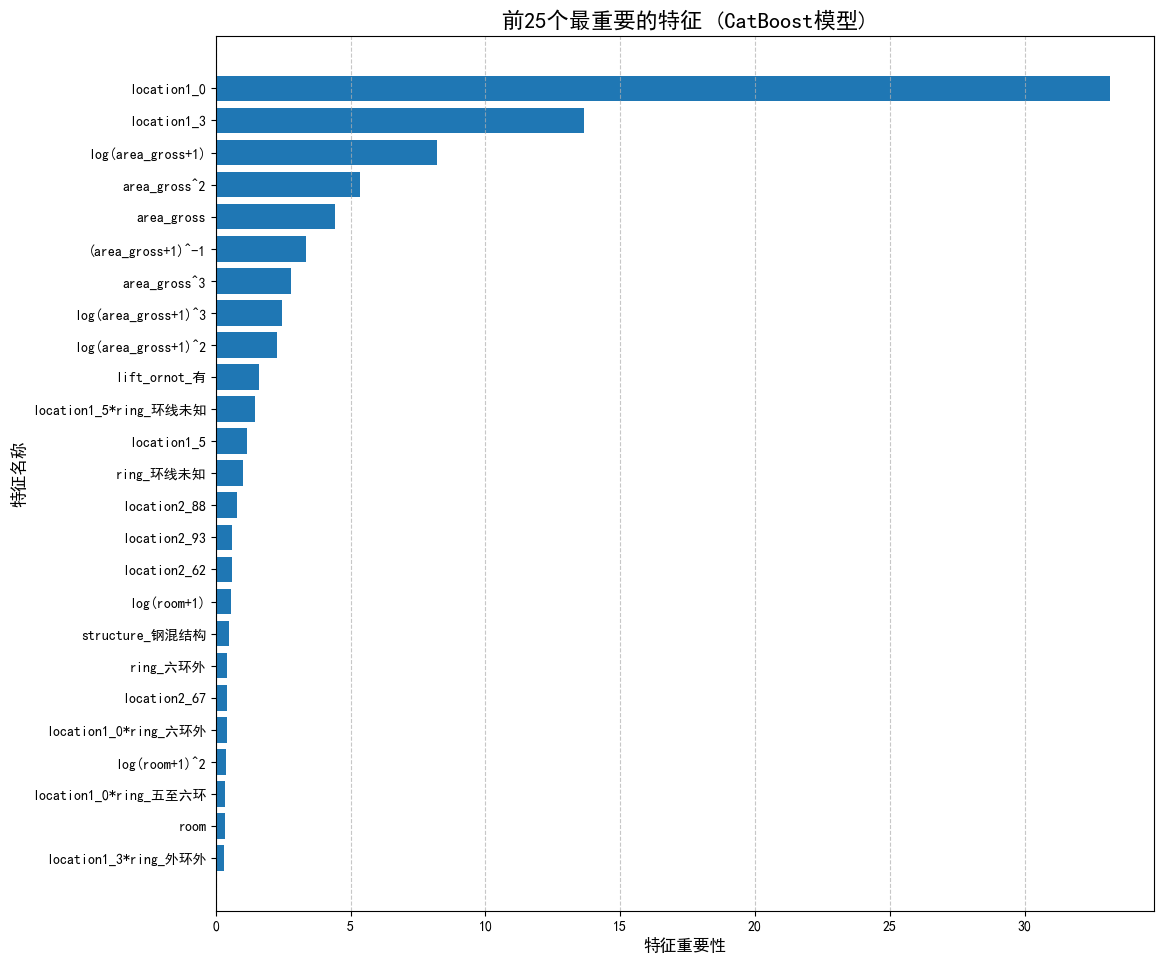

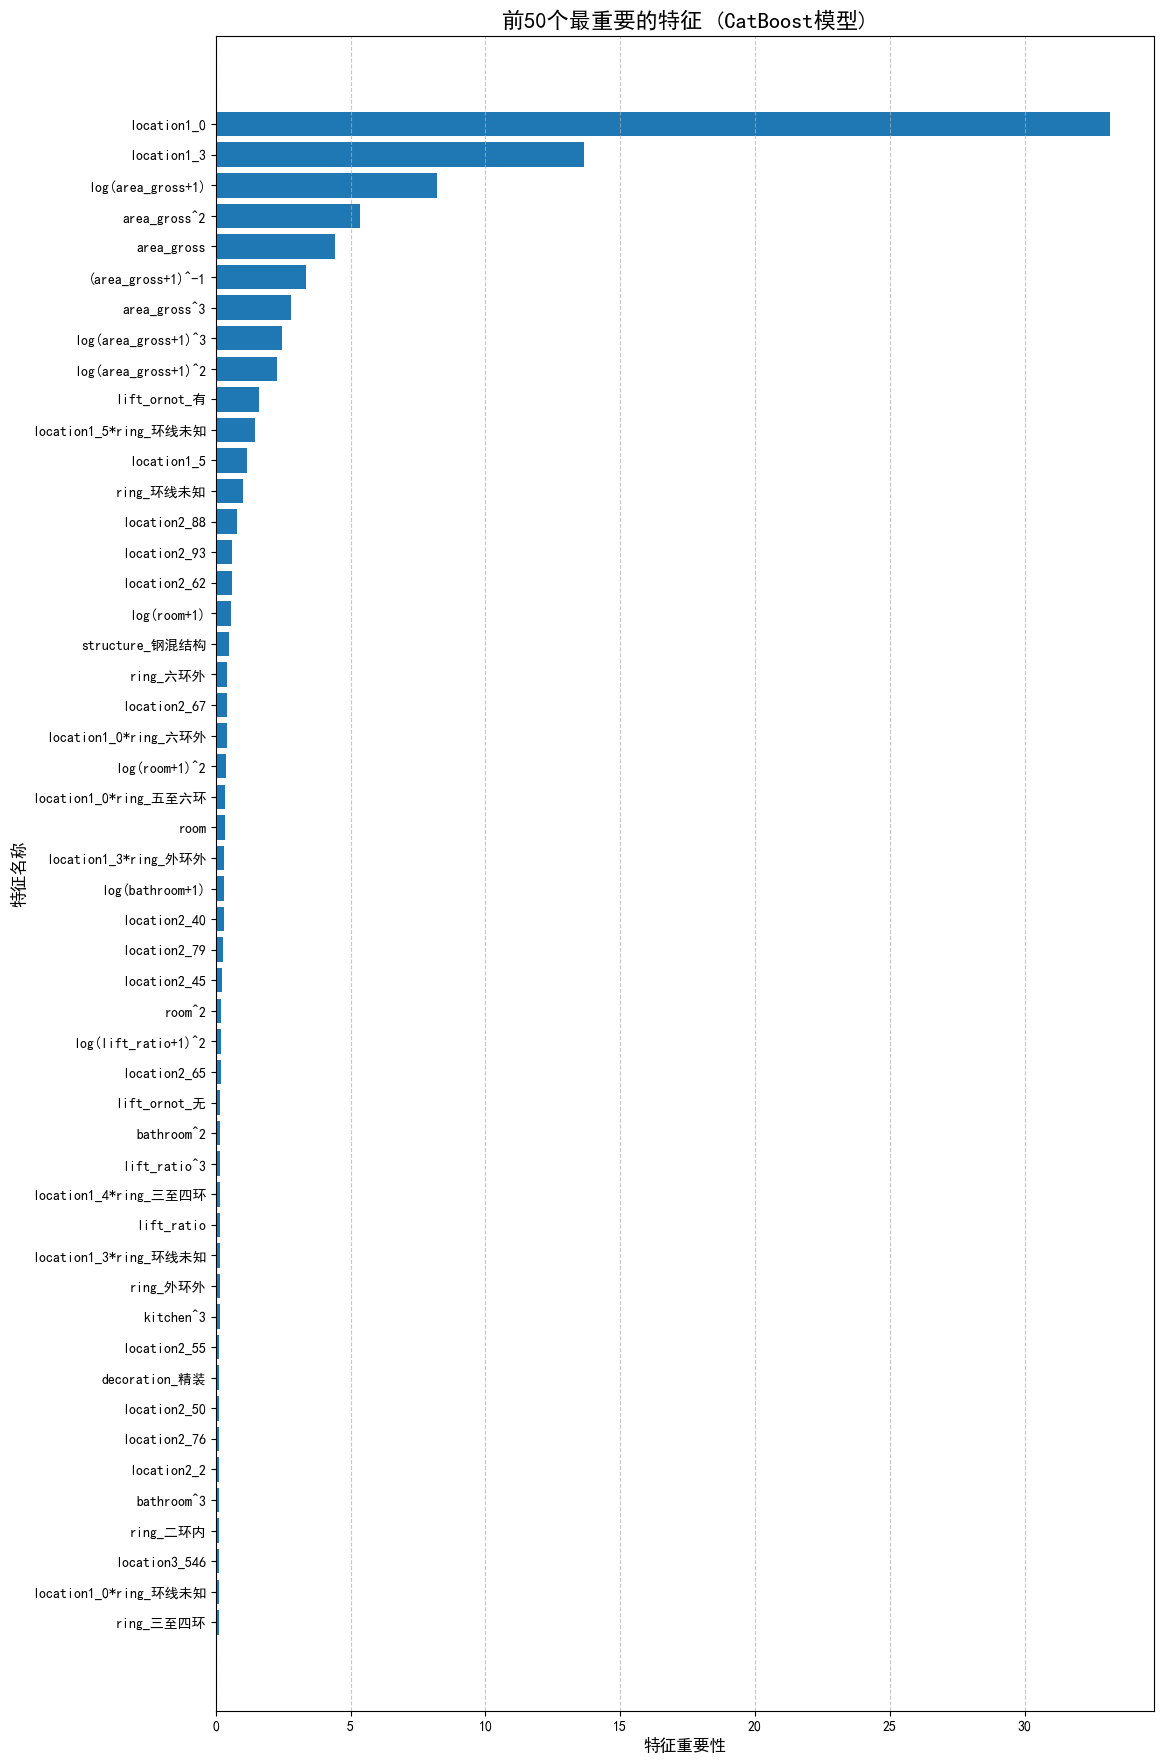

<Figure size 1400x1600 with 0 Axes>

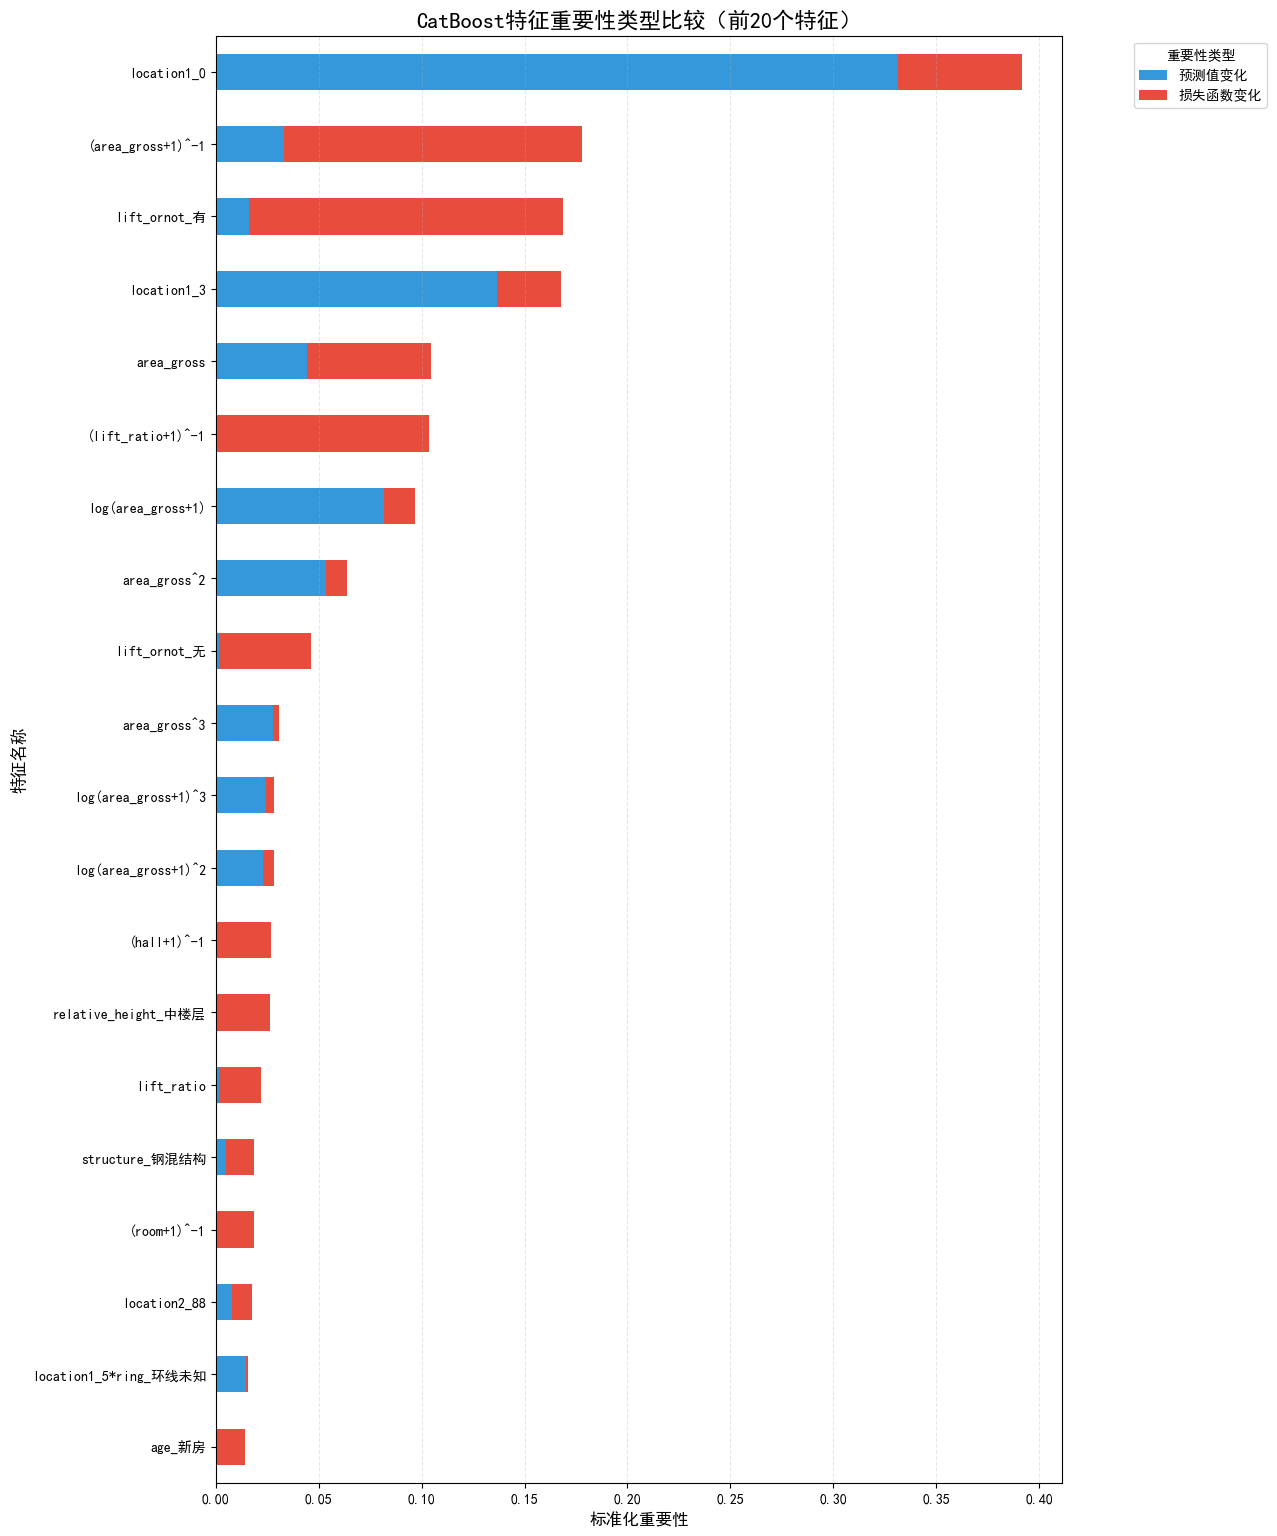

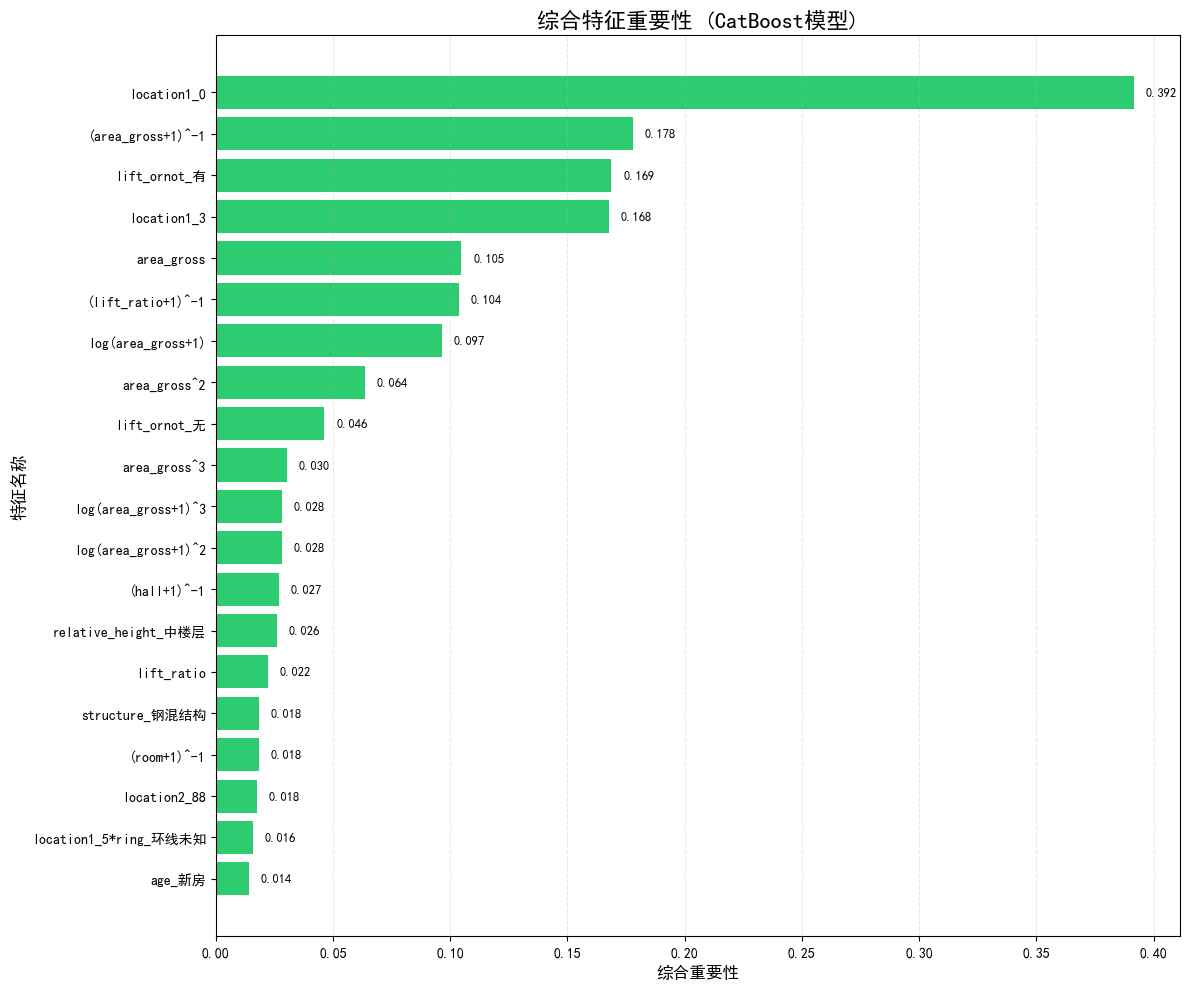

In [3]:
# 载入已经训练好的表现更好的非早停模型
CatBoost_model=joblib.load('CatBoost_nubm_model.joblib')
# 获取CatBoost特征重要性 - 主要使用默认类型
feature_importances = CatBoost_model.get_feature_importance()
feature_names = X_inner.columns

# 创建重要性DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# 打印前20个最重要特征
print("\n=== 特征重要性排序（前20）===")
print(importance_df.head(20))

# 绘制前25特征图表
plt.figure(figsize=(12, 10))
top_25 = importance_df.head(25).sort_values('Importance', ascending=True)
plt.barh(y=top_25['Feature'], width=top_25['Importance'], height=0.8, color='#1f77b4')
plt.title('前25个最重要的特征 (CatBoost模型)', fontsize=16)
plt.xlabel('特征重要性', fontsize=12)
plt.ylabel('特征名称', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2.0)
plt.savefig('CatBoost_feature_importance_top25.png', dpi=300)
print("特征重要性图(前25)已保存")

# 绘制前50特征图表
plt.figure(figsize=(12, 18))
top_50 = importance_df.head(50).sort_values('Importance', ascending=True)
plt.barh(y=top_50['Feature'], width=top_50['Importance'], height=0.8, color='#1f77b4')
plt.title('前50个最重要的特征 (CatBoost模型)', fontsize=16)
plt.xlabel('特征重要性', fontsize=12)
plt.ylabel('特征名称', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2.0)
plt.savefig('CatBoost_feature_importance_top50.png', dpi=300)
print("特征重要性图(前50)已保存")

# 多种重要性类型比较 - 修正版本
print("\n=== 多种重要性类型比较 ===")

# 只使用两种不同的重要性类型
importance_types = ['PredictionValuesChange', 'LossFunctionChange']
type_names = ['预测值变化', '损失函数变化']  # 中文标签

# 创建包含所有重要性类型的DataFrame
multi_importance_df = pd.DataFrame({'Feature': feature_names})

# 创建测试池
test_pool = Pool(X_test, y_test.values.ravel())

# 获取每种重要性类型
for imp_type in importance_types:
    try:
        if imp_type == 'LossFunctionChange':
            scores = CatBoost_model.get_feature_importance(test_pool, type=imp_type)
        else:
            scores = CatBoost_model.get_feature_importance(type=imp_type)
            
        multi_importance_df[imp_type] = scores
        print(f"已计算 {imp_type} 重要性")
    except Exception as e:
        print(f"无法计算 {imp_type} 重要性: {str(e)}")
        multi_importance_df[imp_type] = 0  # 使用0作为占位符

# 标准化每种重要性类型（除以各自的总和）
for imp_type in importance_types:
    total = multi_importance_df[imp_type].sum()
    if total > 0:  # 避免除以0
        multi_importance_df[imp_type] = multi_importance_df[imp_type] / total

# 计算综合重要性（标准化后相加）
multi_importance_df['Combined'] = multi_importance_df[importance_types].sum(axis=1)
multi_importance_df.sort_values('Combined', ascending=False, inplace=True)

# 保存多种重要性类型
multi_importance_df.head(20).to_csv('CatBoost_feature_importance_types.csv')
print("多种重要性类型表已保存")

# 可视化多种重要性类型（标准化后堆叠）
plt.figure(figsize=(14, 16))
top_20_multi = multi_importance_df.head(20).sort_values('Combined', ascending=True)

# 创建水平堆叠条形图
ax = top_20_multi.plot.barh(
    x='Feature',
    y=importance_types,
    stacked=True,
    figsize=(14, 16),
    color=['#3498db', '#e74c3c']  # 蓝色表示预测值变化，红色表示损失函数变化
)

plt.title('CatBoost特征重要性类型比较（前20个特征）', fontsize=16)
plt.xlabel('标准化重要性', fontsize=12)
plt.ylabel('特征名称', fontsize=12)
plt.legend(title='重要性类型', labels=type_names, loc='upper right', bbox_to_anchor=(1.25, 1.0))
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout(pad=3.0)
plt.savefig('CatBoost_feature_importance_comparison.png', dpi=300, bbox_inches='tight')
print("特征重要性类型比较图已保存")

# 可选：绘制综合重要性的水平条形图
plt.figure(figsize=(12, 10))
top_20_combined = top_20_multi.sort_values('Combined', ascending=True)
plt.barh(
    y=top_20_combined['Feature'],
    width=top_20_combined['Combined'],
    height=0.8,
    color='#2ecc71'  # 绿色表示综合重要性
)

# 添加数据标签
for i, (_, row) in enumerate(top_20_combined.iterrows()):
    plt.text(
        row['Combined'] + 0.005,
        i,
        f"{row['Combined']:.3f}",
        va='center',
        fontsize=9
    )

plt.title('综合特征重要性 (CatBoost模型)', fontsize=16)
plt.xlabel('综合重要性', fontsize=12)
plt.ylabel('特征名称', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('CatBoost_combined_feature_importance.png', dpi=300, bbox_inches='tight')
print("综合特征重要性图已保存")

#### 释放CatBoost模型的内存

In [4]:
del CatBoost_model
gc.collect()
print("CatBoost模型内存已释放")

CatBoost模型内存已释放


### 神经网络模型

#### 神经网络模型的调参结果

In [ ]:
import joblib
import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')  # 忽略警告

# 创建用于调参的子集
_, X_subset, _, y_subset = train_test_split(
    X_inner, y_inner, test_size=0.8, random_state=100  # 使用80%的子集
)

print("子集的特征形状:", X_subset.shape)
print("子集的目标形状:", y_subset.shape)

# 标准化输入数据（神经网络对输入尺度敏感）
scaler = StandardScaler()
X_subset_scaled = scaler.fit_transform(X_subset)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_inner_scaled = scaler.transform(X_inner)
X_outer_scaled = scaler.transform(X_outer)

def objective(trial):
    # 固定使用 'adam' 优化器
    params = {
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [
            (128, 64),       # 当前最佳结构
            (256, 128),      # 原候选
            (256, 128, 64),  # 三层结构
            (512, 256),      # 更宽结构
            (512, 256, 128, 64) # 最大网络
        ]),
        'activation': trial.suggest_categorical('activation', ['logistic', 'tanh']),
        'alpha': trial.suggest_float('alpha', 1e-4, 0.1, log=True),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-3, 0.1, log=True),
        'solver': 'adam',  
        'max_iter': trial.suggest_int('max_iter', 300, 1500),
        'batch_size': trial.suggest_categorical('batch_size', [256, 512, 1024, 2048]),
        'early_stopping': True,
        'validation_fraction': 0.1,
        'n_iter_no_change': trial.suggest_int('n_iter_no_change', 10, 30)
    }
    
    # 创建模型
    model = MLPRegressor(
        **params,  
        random_state=321
    )
    
    # 使用3折交叉验证评估
    scores = cross_val_score(
        model, 
        X_subset_scaled, 
        y_subset.values.ravel(), 
        cv=3, 
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    
    return -np.mean(scores)  # 返回平均RMSE（越小越好）

# 运行Optuna调优
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print("最佳超参数:", study.best_params)
best_params = study.best_params


子集的特征形状: (67307, 3976)
子集的目标形状: (67307, 1)


[I 2025-06-04 13:04:52,560] A new study created in memory with name: no-name-114a1c08-5d2a-431d-a7fd-3d3b8ab6034f
[I 2025-06-04 13:17:08,646] Trial 0 finished with value: 0.7421618877616633 and parameters: {'hidden_layer_sizes': (512, 256), 'activation': 'logistic', 'alpha': 0.00051593357791038, 'learning_rate_init': 0.07853598512497552, 'max_iter': 598, 'batch_size': 1024, 'n_iter_no_change': 24}. Best is trial 0 with value: 0.7421618877616633.
[I 2025-06-04 13:26:06,288] Trial 1 finished with value: 0.6357687769517071 and parameters: {'hidden_layer_sizes': (256, 128), 'activation': 'tanh', 'alpha': 0.005499096610547375, 'learning_rate_init': 0.013271990324518663, 'max_iter': 1207, 'batch_size': 1024, 'n_iter_no_change': 29}. Best is trial 1 with value: 0.6357687769517071.
[I 2025-06-04 13:29:26,401] Trial 2 finished with value: 2.6302296793021083 and parameters: {'hidden_layer_sizes': (128, 64), 'activation': 'tanh', 'alpha': 0.00962071048990643, 'learning_rate_init': 0.0058284785300

最佳超参数: {'hidden_layer_sizes': (512, 256, 128, 64), 'activation': 'logistic', 'alpha': 0.0017370333328834994, 'learning_rate_init': 0.0016892514485584694, 'max_iter': 1164, 'batch_size': 512, 'n_iter_no_change': 27}


TypeError: sklearn.neural_network._multilayer_perceptron.MLPRegressor() got multiple values for keyword argument 'n_iter_no_change'

##### ANN模型的最优参数

In [ ]:
nn_model = MLPRegressor(
    hidden_layer_sizes=(512,256,128,64),
    activation='logistic',
    alpha=0.0015758747363977194,
    learning_rate_init=0.0011574250548701738, 
    max_iter=977,
    batch_size=512,
    n_iter_no_change=17,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=321
)

#### ANN模型的训练与模型评价

In [ ]:
# 创建使用最佳参数的最终模型
nn_model = MLPRegressor(
    random_state=321,
    **best_params  
)

# 在训练集上训练模型
nn_model.fit(X_train_scaled, y_train.values.ravel())

# 评估模型性能
def calculate_rmse(model, X, y):
    preds = model.predict(X)
    return np.sqrt(mean_squared_error(np.exp(y), np.exp(preds)))

train_rmse = calculate_rmse(nn_model, X_train_scaled, y_train)
test_rmse = calculate_rmse(nn_model, X_test_scaled, y_test)
print(f"训练集 RMSE: {train_rmse:.4f}")
print(f"测试集 RMSE: {test_rmse:.4f}")

# 在整个内部集上训练最终模型
nn_model.fit(X_inner_scaled, y_inner.values.ravel())

# 保存模型
joblib.dump(nn_model, 'neural_network_model.joblib')

# 生成测试集预测结果
predictions = nn_model.predict(X_outer_scaled)
pd.DataFrame({
    'ID': range(len(predictions)),
    'Price': np.exp(predictions)
}).to_csv('NN_outer_predictions.csv', index=False)

# 评估全内部数据集性能
full_rmse = calculate_rmse(nn_model, X_inner_scaled, y_inner)
print(f"全内部样本 RMSE: {full_rmse:.4f}")



# 重新加载模型
nn_model = joblib.load('neural_network_model.joblib')

# 分析训练损失曲线
if hasattr(nn_model, 'loss_curve_'):
    plt.figure(figsize=(10, 6))
    plt.plot(nn_model.loss_curve_, label='训练损失')
    plt.title('模型训练损失')
    plt.ylabel('损失')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7)
    plt.savefig('nn_training_history.png', dpi=300, bbox_inches='tight')
    print("训练历史图已保存至 nn_training_history.png")
else:
    print("警告：无法获取训练损失曲线")

# 特征排列重要性
print("\n计算特征排列重要性...")

# 使用测试集计算（更快）
result = permutation_importance(
    nn_model, 
    X_test_scaled, 
    y_test.values.ravel(),
    n_repeats=5,  # 减少重复次数以加快计算
    random_state=42,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# 创建重要性DataFrame
importance_df = pd.DataFrame({
    'Feature': X_inner.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values('Importance', ascending=False)

# 打印前20个最重要特征
print("\n=== 特征重要性排序（前20）===")
print(importance_df.head(20))

# 可视化重要性（显示前25个特征）
plt.figure(figsize=(12, 10))
top_25 = importance_df.head(25).sort_values('Importance', ascending=True)

# 使用Matplotlib创建水平条形图
plt.barh(
    y=top_25['Feature'],
    width=top_25['Importance'],
    height=0.8,
    color='#3498db',  # 蓝色
    edgecolor='gray'
)

# 为前5个最重要的特征添加数据标签
for i in range(20, 25):  # 仅对前5重要特征添加标签
    importance = top_25.iloc[i]['Importance']
    plt.text(
        importance + 0.005 * abs(importance),  # 自适应偏移量
        i,
        f"{importance:.4f}",
        va='center',
        ha='left',
        fontsize=10
    )

plt.title('前25个最重要的特征 (神经网络模型)', fontsize=16)
plt.xlabel('排列重要性分数', fontsize=12)
plt.ylabel('特征名称', fontsize=12)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2.0)
plt.savefig('NN_feature_importance.png', dpi=300, bbox_inches='tight')
print("特征重要性图已保存至 NN_feature_importance.png")

# 可视化前50个特征
plt.figure(figsize=(12, 18))
top_50 = importance_df.head(50).sort_values('Importance', ascending=True)
plt.barh(
    y=top_50['Feature'],
    width=top_50['Importance'],
    height=0.8,
    color='#3498db',
    edgecolor='gray'
)

plt.title('前50个最重要的特征 (神经网络模型)', fontsize=16)
plt.xlabel('排列重要性分数', fontsize=12)
plt.ylabel('特征名称', fontsize=12)
plt.yticks(fontsize=9)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2.0)
plt.savefig('NN_feature_importance_top50.png', dpi=300, bbox_inches='tight')
print("特征重要性图(前50)已保存至 NN_feature_importance_top50.png")

训练集 RMSE: 316003.2424
测试集 RMSE: 740317.0590
全内部样本 RMSE: 407015.5190

模型训练完成，进行交叉验证评估...

训练折叠 #1


TypeError: sklearn.neural_network._multilayer_perceptron.MLPRegressor() got multiple values for keyword argument 'n_iter_no_change'

In [67]:
# 模型交叉验证评估
print("\n模型训练完成，进行交叉验证评估...")

# 自定义RMSE评分器
def nn_rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.exp(y_true), np.exp(y_pred)))

# 创建K折交叉验证
kf = KFold(n_splits=3, shuffle=True, random_state=321)
rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_inner)):
    print(f"\n训练折叠 #{fold+1}")
    
    # 划分训练/验证集
    X_train_fold, X_val_fold = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
    y_train_fold, y_val_fold = y_inner.iloc[train_idx], y_inner.iloc[val_idx]
    
    # 标准化数据（重新拟合缩放器）
    fold_scaler = StandardScaler()
    X_train_fold_scaled = fold_scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = fold_scaler.transform(X_val_fold)
    
    # 创建模型（使用最佳参数）
    fold_model = MLPRegressor(
        random_state=321,
        **best_params
    )
    
    # 训练模型
    fold_model.fit(X_train_fold_scaled, y_train_fold.values.ravel())
    
    # 评估模型
    val_preds = fold_model.predict(X_val_fold_scaled)
    rmse = nn_rmse_scorer(y_val_fold, val_preds)
    rmse_scores.append(rmse)
    print(f"折叠 #{fold+1} RMSE: {rmse:.4f}")

print(f"\n交叉验证 RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")


模型训练完成，进行交叉验证评估...

训练折叠 #1
折叠 #1 RMSE: 951780.9555

训练折叠 #2
折叠 #2 RMSE: 799991.3594

训练折叠 #3
折叠 #3 RMSE: 695145.9629

交叉验证 RMSE: 815639.4259 ± 105353.4570


### 补充期中考试中的最优模型：OLS

In [ ]:
from sklearn.linear_model import LinearRegression

OLS_model = LinearRegression()
OLS_model.fit(X_inner,y_inner.values.ravel())
joblib.dump(OLS_model, 'OLS_model.joblib')

predictions = OLS_model.predict(X_outer)
pd.DataFrame({
    'ID': range(len(predictions)),
    'Price': np.exp(predictions)
}).to_csv('OLS_outer_predictions.csv', index=False)


### 模型加权

#### 简单加权

In [23]:
prediction_list=[]
prediction_list.append(pd.read_csv('OLS_outer_predictions.csv'))
#prediction_list.append(pd.read_csv('RF_outer_predictions.csv'))
#prediction_list.append(pd.read_csv('XGBoost_outer_predictions.csv'))
#prediction_list.append(pd.read_csv('LightGBM_outer_predictions.csv'))
#prediction_list.append(pd.read_csv('CatBoost_ubm_outer_predictions.csv'))
prediction_list.append(pd.read_csv('NN_outer_predictions.csv'))
mean_predictions=[0]*len(prediction_list[0])
for k in range(len(prediction_list)):
    mean_predictions+=prediction_list[k]['Price']
pd.DataFrame({
    'ID': range(len(prediction_list[0])),
    'Price': mean_predictions/len(prediction_list)
}).to_csv('integrated_outer_predictions.csv', index=False)
print(mean_predictions)

0        4.356007e+07
1        2.115629e+07
2        7.019369e+06
3        5.033910e+06
4        1.170916e+07
             ...     
14781    1.115493e+06
14782    1.433871e+06
14783    2.205145e+06
14784    2.423535e+06
14785    1.606001e+06
Name: Price, Length: 14786, dtype: float64


#### 性能加权法

In [ ]:
Y_inner_hat=pd.DataFrame(
{
    'OLS_pre':np.exp(OLS_model.predict(X_inner)),
    'NN_pre':np.exp(nn_model.predict(X_inner))
}
)

import statsmodels.api as sm
weight_model = sm.OLS(np.exp(y_inner), Y_inner_hat).fit()
print(weight_model.summary())

Y_outer_hat=pd.DataFrame(
{
    'OLS_pre':prediction_list[0]['Price'],
    'NN_pre':prediction_list[1]['Price']
}
)
predictions=weight_model.predict(Y_outer_hat)
pd.DataFrame({
    'ID': range(len(ensemble_pred)),
    'Price': predictions
}).to_csv('weighted_2_ensemble_predictions.csv', index=False)

#### 去极端值加权法

In [55]:
print(np.mean(np.exp(y_inner.values.ravel())))
print(np.max(np.exp(y_inner.values.ravel())))
print(np.mean(Y_inner_hat['OLS_pre']))
print(np.max(Y_inner_hat['OLS_pre']))
print(np.mean(Y_inner_hat['NN_pre']))
print(np.max(Y_inner_hat['NN_pre']))
print(np.mean(Y_inner_hat['OLS_pre']/np.exp(y_inner.values.ravel())))
print(np.max(Y_inner_hat['OLS_pre']/np.exp(y_inner.values.ravel())))
print(np.min(Y_inner_hat['OLS_pre']/np.exp(y_inner.values.ravel())))
print(np.mean(Y_inner_hat['NN_pre']/np.exp(y_inner.values.ravel())))
print(np.max(Y_inner_hat['NN_pre']/np.exp(y_inner.values.ravel())))
print(np.min(Y_inner_hat['NN_pre']/np.exp(y_inner.values.ravel())))

1971952.635588889
79950000.00000015
1959609.0951187343
93989414.50195712
1799077.871356149
2314753.541120169
1.0084845535354399
5.519705161211063
0.18457476661360683
2.084622160584001
28.610853156954377
0.019421969720602127


In [45]:
sigma2=np.var(y_inner.values.ravel())
print(sigma2)
print(np.mean(np.exp(OLS_model.predict(X_inner)+sigma2/2)))
print(np.mean(np.exp(nn_model.predict(X_inner)+sigma2/2)))

0.7914810073657886
2910967.5454559736
2672501.014774299


In [68]:
std_dv=np.sqrt(np.var(np.exp(y_inner.values.ravel())))
print(std_dv)
predictions=np.where(np.abs(prediction_list[0]['Price']-prediction_list[1]['Price'])>6*std_dv,prediction_list[0]['Price'],0.7*prediction_list[0]['Price']+0.3*prediction_list[1]['Price'])
pd.DataFrame({
    'ID': range(len(ensemble_pred)),
    'Price': predictions
}).to_csv('weighted_3_ensemble_predictions.csv', index=False)

2639946.7415135894


#### 随机森林模型加权

[I 2025-06-04 21:07:18,857] A new study created in memory with name: no-name-4bbc6e5d-28ce-416d-b84f-9d15ec39a923


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-04 21:07:30,305] Trial 0 finished with value: 526354.3753728447 and parameters: {'n_estimators': 154, 'max_depth': 19, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': 0.42891533440226903, 'bootstrap': True}. Best is trial 0 with value: 526354.3753728447.
[I 2025-06-04 21:07:54,495] Trial 1 finished with value: 500903.7285743728 and parameters: {'n_estimators': 481, 'max_depth': 29, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 0.4177940010789374, 'bootstrap': True}. Best is trial 1 with value: 500903.7285743728.
[I 2025-06-04 21:08:03,097] Trial 2 finished with value: 505402.45537184103 and parameters: {'n_estimators': 190, 'max_depth': 49, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 0.4787057836824139, 'bootstrap': True}. Best is trial 1 with value: 500903.7285743728.
[I 2025-06-04 21:08:31,437] Trial 3 finished with value: 495180.1796910514 and parameters: {'n_estimators': 471, 'max_depth': 16, 'min_samples_split': 10, '

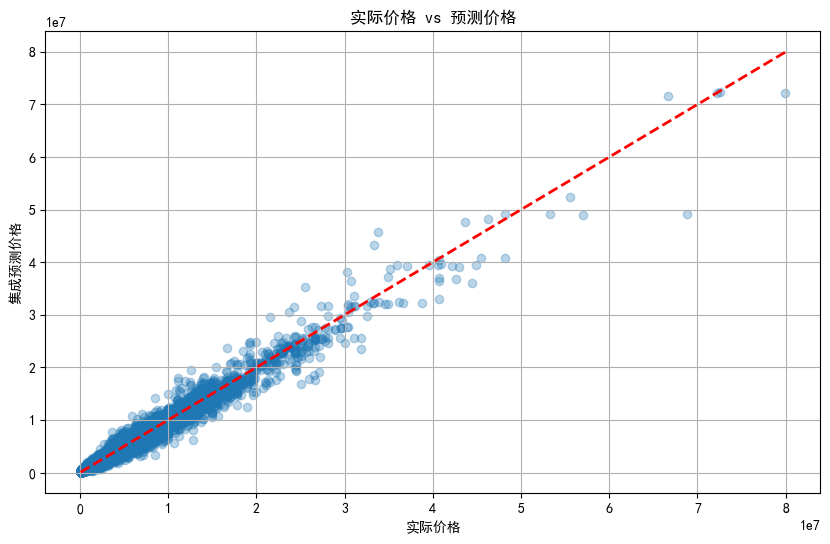

In [56]:
NN_model = joblib.load('neural_network_model.joblib')
OLS_model = joblib.load('OLS_model.joblib')


# 获取两个模型的预测结果
nn_pred = np.exp(nn_model.predict(X_inner))
ols_pred = np.exp(OLS_model.predict(X_inner))

# 创建元特征数据集（基础模型预测作为特征）
meta_features = np.column_stack((nn_pred, ols_pred))
meta_target = np.exp(y_inner.values.ravel())  # 转换为实际价格（如果y_inner是对数变换过的）

# 划分元训练集和验证集
X_meta_train, X_meta_val, y_meta_train, y_meta_val = train_test_split(
    meta_features, meta_target, test_size=0.2, random_state=42
)

# 创建RMSE评分器
rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

# 定义Optuna目标函数
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42
    }
    
    # 创建随机森林模型
    model = RandomForestRegressor(**params)
    
    # 使用交叉验证评估
    scores = cross_val_score(
        model, X_meta_train, y_meta_train, 
        cv=3, scoring=rmse_scorer, n_jobs=-1
    )
    
    # 返回平均RMSE（由于greater_is_better=False，这里是负RMSE）
    return -np.mean(scores)

# 创建并运行Optuna研究
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("最佳参数:", study.best_params)
print(f"最佳交叉验证RMSE: {-study.best_value:.4f}")

# 使用最佳参数训练最终元模型
best_params = study.best_params
integrate_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    bootstrap=best_params['bootstrap'],
    random_state=42
)

# 在整个元训练集上训练（包含验证集）
integrate_model.fit(np.vstack([X_meta_train, X_meta_val]), 
             np.concatenate([y_meta_train, y_meta_val]))

# 在验证集上评估
y_meta_val_pred = integrate_model.predict(X_meta_val)
val_rmse = np.sqrt(mean_squared_error(y_meta_val, y_meta_val_pred))
print(f"最终元模型在验证集上的RMSE: {val_rmse:.4f}")

# 保存元模型
joblib.dump(integrate_model, 'random_forest_meta_model.joblib')

# 定义预测函数
def ensemble_predict(X):
    """预测新数据的集成结果"""
    # 获取基础模型预测
    nn_pred = np.exp(NN_model.predict(X))
    ols_pred = np.exp(OLS_model.predict(X))
    
    # 组合预测作为元特征
    meta_features = np.column_stack((nn_pred, ols_pred))
    
    # 使用元模型进行最终预测
    return integrate_model.predict(meta_features)

predictions = ensemble_predict(X_outer)

# 保存预测结果
pd.DataFrame({
    'ID': range(len(predictions)),
    'Price': predictions
}).to_csv('RF_ensemble_predictions.csv', index=False)

# 分析特征重要性
feature_importances = pd.DataFrame({
    'Feature': ['Neural_Network_Prediction', 'OLS_Prediction'],
    'Importance': integrate_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n元模型特征重要性:")
print(feature_importances)

# 可视化预测结果对比
plt.figure(figsize=(10, 6))
plt.scatter(np.exp(y_inner), ensemble_predict(X_inner), alpha=0.3)
plt.plot([min(meta_target), max(meta_target)], 
         [min(meta_target), max(meta_target)], 
         'r--', lw=2)
plt.xlabel('实际价格')
plt.ylabel('集成预测价格')
plt.title('实际价格 vs 预测价格')
plt.grid(True)
plt.savefig('ensemble_prediction_scatter.png', dpi=300)